# Obligatorio Técnicas de Machine Learning

Florencia Sarasua 141547

Valentina Caffera 157289

Martin Martinez   308676

*Nota: el dataset utilizado para este proyecto fue extraido de https://www.ine.gub.uy/Anda5/index.php/catalog/730/download/1155, dado su tamaño no es posible incluirlo en el repositorio de GitHub.*

In [258]:
import warnings
warnings.filterwarnings("ignore")

In [259]:
#Importar librerías
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split # División del dataset
from sklearn.linear_model import LinearRegression # Modelo de ML
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix # Métricas
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go

In [261]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import StackingClassifier

## Selección de variables

In [262]:
#df_original = pd.read_csv(r'data\ECH_2022.csv')
df_original = pd.read_csv(r'ECH_2022.csv')

In [263]:
df_original.head()

,ID,nper,anio,mes,GR,region,region_4,dpto,ccz,secc,...,w_tri,w_sem,estred13,nom_dpto,g260,g261,g261_1,w_ano,Loc_agr_13,Nom_loc_agr_13
0,11558,1,2022,1,7,1,1,1,1,4,...,175,87.5,4,MONTEVIDEO,NaN,NaN,NaN,38,1010,Montevideo
1,11559,1,2022,1,7,1,1,1,1,4,...,350,175.0,4,MONTEVIDEO,NaN,NaN,NaN,84,1010,Montevideo
2,11559,2,2022,1,7,1,1,1,1,4,...,350,175.0,4,MONTEVIDEO,NaN,NaN,NaN,84,1010,Montevideo
3,11560,1,2022,1,7,1,1,1,1,4,...,131,65.5,4,MONTEVIDEO,NaN,NaN,NaN,33,1010,Montevideo
4,11561,1,2022,1,7,1,1,1,1,4,...,131,65.5,4,MONTEVIDEO,NaN,NaN,NaN,33,1010,Montevideo


In [265]:
columns = df_original.columns.values.tolist()

## Preparación de los datos

##### Validamos que todas las personas de un mismo hogar están clasificadas de la misma manera

Dicho de otra manera: no hay hogares con integrantes pobres y no pobres en la base de datos.

In [266]:
df=pd.DataFrame()
df['id_hogar'] = df_original['ID'].astype('string')
df['id_per'] = df_original['nper'].astype('string')
df['pobre'] = df_original['pobre'].astype('int64')

#creamos un identificador único de persona
df['id']= df['id_hogar'] + '_' + df['id_per']

In [267]:
# Verifica si existen hogares donde hay más de un valor único de pobre (personas pobres y no pobres en el mismo hogar)

result = df.groupby('id_hogar')['pobre'].nunique()

hay_mixto = (result > 1).any()

if hay_mixto:
    print("Existen casos donde el mismo id_hogar tiene personas clasificadas como pobres y no pobres.")
else:
    print("No existen casos donde el mismo id_hogar tiene personas clasificadas como pobres y no pobres.")

No existen casos donde el mismo id_hogar tiene personas clasificadas como pobres y no pobres.


### Creación del dataset

#### Se decide diferenciar variables relativas al hogar y variables socio-demograficas.
A continuación se detallan las variables a incluir en el modelo a trabajar.

#### Variables referentes a Hogar

departamento: indica el departamento de residencia de la persona.

q_auto: cantidad de autos que posee el encuestado.

internet: indica si el hogar posee acceso a internet.

tipo_vivienda: refiere al tipo de vivienda en el que habita el encuestado.

material_paredes: variable que especifica el tipo de material de construcción que predomina en las paredes de la vivienda.

material_techo: variable que especifica el tipo de material de construcción que predomina en el techo de la vivienda.

material_pisos: variable que especifica el tipo de material de construcción que predomina en el piso de la vivienda.

tenencia_vivienda: esta variable indica si la persona es propietaria, inquilina u ocupante entre otras opciones.

nro_habitaciones: informa la cantidad de habitaciones que posee el hogar del encuestado.

nro_baños: informa la cantidad de baños que posee el hogar del encuestado.

q_pers_hogar: muestra la cantidad de personas que habitan el mismo hogar.

q_menores_14_hogar: muestra la cantidad de personas menores de 14 años que habitan el mismo hogar.

q_hogares_vivienda: indica la cantidad de hogares asociados a una misma vivienda (finalmente, esta variable se excluirá del modelo dado que no aporta valor).

cant_tv_color: indica la cantidad de televisores a color que hay en un hogar.

cant_tv_lcd: indica la cantidad de televisores lcd, plasma, etc que hay en un hogar.

ss_domestico: variable que informa si el hogar cuenta o no con servicio doméstico.

aire_acond: variable que informa si el hogar cuenta o no con aire acondicionado.


#### Variables socio-demograficas

sexo: indica el sexo del encuestado.

edad: informa la edad del encuestado.

anios_educ: variable que muestra la cantidad de años de educación formal que tiene la persona encuestada.

trabajo: indica si la persona trabajó la semana anterior

categoria: indica la categoría ocupacional del encuestado.

caja_jubilaciones: informa a donde realizan los aportes las personas que trabajan (BPS, AFAP, Caja profesionales, etc).

dimension_empresa: variable que indica la cantidad de personas que trabajan en la empresa donde trabaja el encuestado.

horas_trab_sem: en esta variable se incluye la cantidad de horas trabajadas por el encuestado en la semana anterior.

jubilado: indica si la persona encuestada es o no jubilada.

pensionista: indica si la persona encuestada es o no pensionista.

rentista: indica si la persona encuestada es o no rentista.

actividad_economica: en esta variable se informa la actividad por la cual percibe ingresos la persona encuestada, o en contraparte si la persona es desocupada.

subempleo: informa si la persona es sub-empleada.

salud: indica si la persona tiene acceso a servicios de salud, y a qué tipo de servicio accede.

In [268]:
# Características del hogar
df['departamento'] = df_original['dpto'].astype('category')
df['q_auto']= df_original['d21_18_1'].astype('int64')
df['internet']=  df_original['d21_16'].astype('category')
df['tipo_vivienda'] = df_original['c1'].astype('category')
df['material_paredes'] = df_original['c2'].astype('category')
df['material_techo'] = df_original['c3'].astype('category')
df['material_pisos'] = df_original['c4'].astype('category')
df['tenencia_vivienda'] = df_original['d8_1'].astype('category')
df['nro_habitaciones'] = df_original['d9'].astype('int64')
df['nro_baños'] = df_original['d14'].astype('int64')
df['q_pers_hogar'] = df_original['HT19']
df['q_menores_14_hogar'] = df_original['d24']
df['q_hogares_vivienda']=df_original['c6']
df['cant_tv_color']=df_original['d21_4_1'].astype('int64')
df['cant_tv_lcd']=df_original['d21_5_1'].astype('int64')
df['ss_domestico'] = df_original['d181'].astype('category')
df['aire_acond']=df_original['d21_14'].astype('category')

# Características de los integrantes del hogar
df['sexo']=df_original['e26'].astype('category')
df['edad']=df_original['e27']
df['anios_educ'] = df_original['e51_1'] + df_original['e51_2'] + df_original['e51_3'] + df_original['e51_4_a'] + df_original['e51_4_b'] \
                   + df_original['e51_5'] + df_original['e51_6'] + df_original['e51_8'] + df_original['e51_9']  + df_original['e51_10'] + df_original['e51_11']
df['trabajo']=df_original['f269'].astype('category')
df['categoria']=df_original['f73'].astype('category')
df['caja_jubilaciones']=df_original['f83'].astype('category')
df['dimension_empresa']=df_original['f77'].astype('category')
df['horas_trab_sem']=df_original['f297']
df['jubilado']=df_original['f124_1'].astype('category')
df['pensionista']=df_original['f124_2'].astype('category')
df['rentista']=df_original['f124_3'].astype('category')
df['actividad_economica']=df_original['POBPCOAC'].astype('category')
df['subempleo']=df_original['SUBEMPLEO'].astype('category')
df['salud']=df_original['e45_cv'].astype('category')

In [269]:
df.head()

,id_hogar,id_per,pobre,id,departamento,q_auto,internet,tipo_vivienda,material_paredes,material_techo,...,categoria,caja_jubilaciones,dimension_empresa,horas_trab_sem,jubilado,pensionista,rentista,actividad_economica,subempleo,salud
0,11558,1,0,11558_1,1,0,1,3,1,1,...,0,0,0,0,1,2,2,10,0.0,2
1,11559,1,0,11559_1,1,1,1,3,1,1,...,1,2,8,0,2,2,2,2,0.0,2
2,11559,2,0,11559_2,1,1,1,3,1,1,...,1,1,2,0,2,2,1,2,0.0,2
3,11560,1,0,11560_1,1,1,1,3,1,1,...,1,7,5,0,2,2,1,2,0.0,2
4,11561,1,0,11561_1,1,1,1,3,1,1,...,9,5,1,0,2,2,2,2,0.0,2


#### Variables

Analizamos el tipo de datos de cada una de las variables del dataframe.

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55056 entries, 0 to 55055
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id_hogar             55056 non-null  string  
 1   id_per               55056 non-null  string  
 2   pobre                55056 non-null  int64   
 3   id                   55056 non-null  string  
 4   departamento         55056 non-null  category
 5   q_auto               55056 non-null  int64   
 6   internet             55056 non-null  category
 7   tipo_vivienda        55056 non-null  category
 8   material_paredes     55056 non-null  category
 9   material_techo       55056 non-null  category
 10  material_pisos       55056 non-null  category
 11  tenencia_vivienda    55056 non-null  category
 12  nro_habitaciones     55056 non-null  int64   
 13  nro_baños            55056 non-null  int64   
 14  q_pers_hogar         55056 non-null  int64   
 15  q_menores_14_hogar 

## Análisis estadístico descriptivo y transformaciones de variables

In [271]:
df.pobre.value_counts(normalize=True)

0    0.915577
1    0.084423
Name: pobre, dtype: float64

8,44% de las personas de la muestra son pobres.

Es un dataset desbalanceado

#### Variables relativas al hogar & socio demográficas

In [272]:
# Definir las columnas de tu dataset
id_hogar = "id_hogar"
id_per = "id_per"
pobre = "pobre"
id_col = "id"
departamento = "departamento"
q_auto = "q_auto"
internet = "internet"
tipo_vivienda = "tipo_vivienda"
material_paredes = "material_paredes"
material_techo = "material_techo"
material_pisos = "material_pisos"
tenencia_vivienda = "tenencia_vivienda"
nro_habitaciones = "nro_habitaciones"
nro_baños = "nro_baños"
q_pers_hogar = "q_pers_hogar"
q_menores_14_hogar = "q_menores_14_hogar"
q_hogares_vivienda = "q_hogares_vivienda"
cant_tv_color = "cant_tv_color"
cant_tv_lcd = "cant_tv_lcd"
ss_domestico = "ss_domestico"
aire_acond = "aire_acond"
sexo = "sexo"
edad = "edad"
anios_educ = "anios_educ"
trabajo = "trabajo"
categoria = "categoria"
caja_jubilaciones = "caja_jubilaciones"
dimension_empresa = "dimension_empresa"
horas_trab_sem = "horas_trab_sem"
actividad_economica = "actividad_economica"
subempleo = "subempleo"
salud = "salud"

# Se crea la lista "hogar" con las variables hasta q_aire_acond
hogar = [ pobre, departamento, q_auto, internet, tipo_vivienda,  material_paredes, material_techo, material_pisos,
        tenencia_vivienda, nro_habitaciones,  nro_baños, q_pers_hogar, q_menores_14_hogar, q_hogares_vivienda, 
        cant_tv_color,cant_tv_lcd, ss_domestico,   aire_acond]

# Se crea la lista "socio_demograficas" con el resto de las variables
socio_demograficas = [ pobre,sexo, edad, anios_educ, trabajo, categoria, caja_jubilaciones, dimension_empresa,
                    horas_trab_sem, actividad_economica, subempleo, salud]

**Análisis descriptivo de variables relativas al hogar**

In [273]:
df[hogar].describe()

,pobre,q_auto,nro_habitaciones,nro_baños,q_pers_hogar,q_menores_14_hogar,q_hogares_vivienda,cant_tv_color,cant_tv_lcd
count,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000
mean,0.084423,0.599753,3.585077,1.214454,3.157821,0.669137,1.006884,0.143581,1.518799
std,0.278024,0.651388,1.188153,0.543168,1.564394,0.986633,0.082684,0.413908,0.967143
min,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,1.000000,3.000000,1.000000,3.000000,0.000000,1.000000,0.000000,1.000000
75%,0.000000,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,0.000000,2.000000
max,1.000000,5.000000,14.000000,6.000000,12.000000,8.000000,2.000000,4.000000,8.000000


**Análisis descriptivo de variables relativas a las personas**

In [274]:
df[socio_demograficas].describe()

,pobre,edad,anios_educ,horas_trab_sem
count,55056.000000,55056.000000,55056.000000,55056.000000
mean,0.084423,40.995768,11.785201,1.167393
std,0.278024,23.613868,235.962594,5.295478
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,6.000000,0.000000
50%,0.000000,41.000000,10.000000,0.000000
75%,0.000000,60.000000,14.000000,0.000000
max,1.000000,103.000000,55362.000000,67.000000


In [275]:
#A partir de analizar el describe borramos persona con años de educacion atipicos (55362), entendemos que puede haber existido un error de tipeo
df = df.drop(df[df['anios_educ'] == 55362].index)

In [276]:
#Analizamos presencia de datos nulos o faltantes
null_counts = df.isnull().sum()
print(null_counts)

id_hogar                  0
id_per                    0
pobre                     0
id                        0
departamento              0
q_auto                    0
internet                  0
tipo_vivienda             0
material_paredes          0
material_techo            0
material_pisos            0
tenencia_vivienda         0
nro_habitaciones          0
nro_baños                 0
q_pers_hogar              0
q_menores_14_hogar        0
q_hogares_vivienda        0
cant_tv_color             0
cant_tv_lcd               0
ss_domestico              0
aire_acond                0
sexo                      0
edad                      0
anios_educ                0
trabajo                   0
categoria                 0
caja_jubilaciones         0
dimension_empresa         0
horas_trab_sem            0
jubilado                  0
pensionista               0
rentista                  0
actividad_economica       0
subempleo              4678
salud                     0
dtype: int64


Notamos una presencia importante de valores nulos en la variable subempleo.

Lo tendremos en cuenta al momento de definir si utilizamos la misma o no en el modelo.

El resto de las variables no tienen valores nulos.

### Variables hogar

#### Distribuciones

Se plantean gráficas para representar como se distribuyen los resultados de cada una de las variables relativas al hogar.

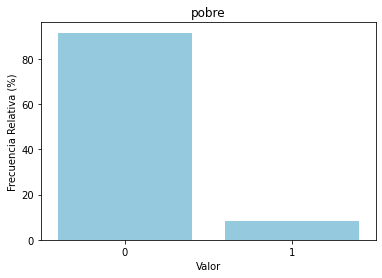

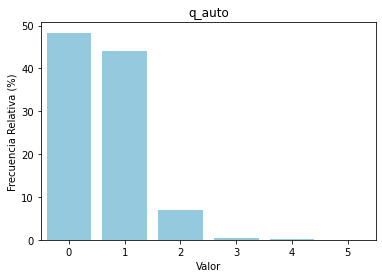

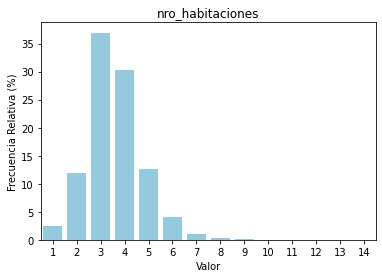

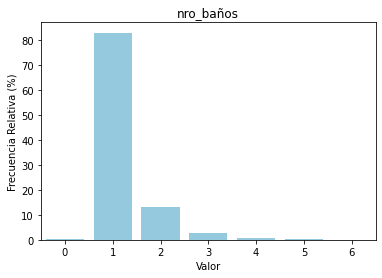

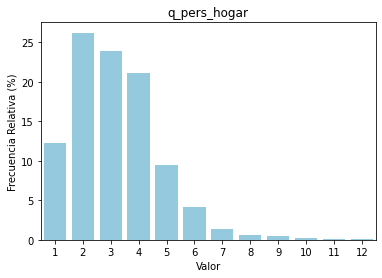

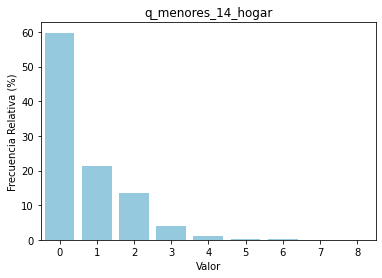

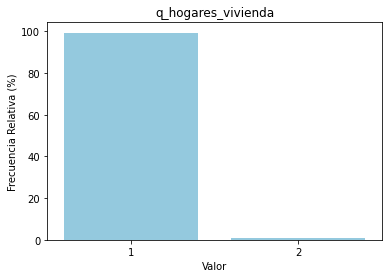

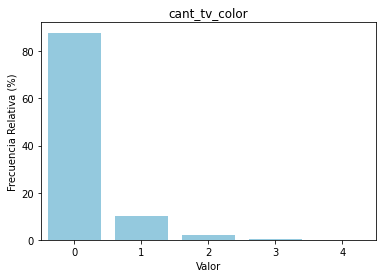

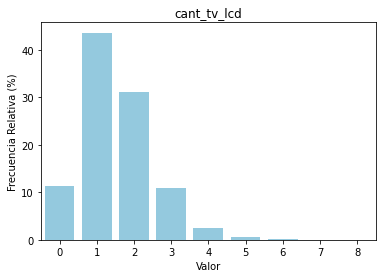

In [277]:
columnas_numericas = df[hogar].select_dtypes(include='number').columns

for columna in columnas_numericas:
    plt.figure(figsize=(6, 4))
    
    # Calcular la frecuencia relativa
    freq_rel = df[columna].value_counts(normalize=True) * 100
    
    # Graficar la frecuencia relativa
    ax = sns.barplot(x=freq_rel.index, y=freq_rel.values, color="skyblue")
    
    plt.title(columna)
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia Relativa (%)")
    
    plt.show()

#### Nro hogares en la vivienda:
En principio consideramos que podria ser una variable util para predecir pobreza, pero la descartamos porque el 99% de las respuestas tienen el mismo valor.

In [278]:
df = df.drop('q_hogares_vivienda', axis=1)
hogar.remove('q_hogares_vivienda')

### Representación grafica de relaciones entre pobreza y variables relacionadas al hogar 

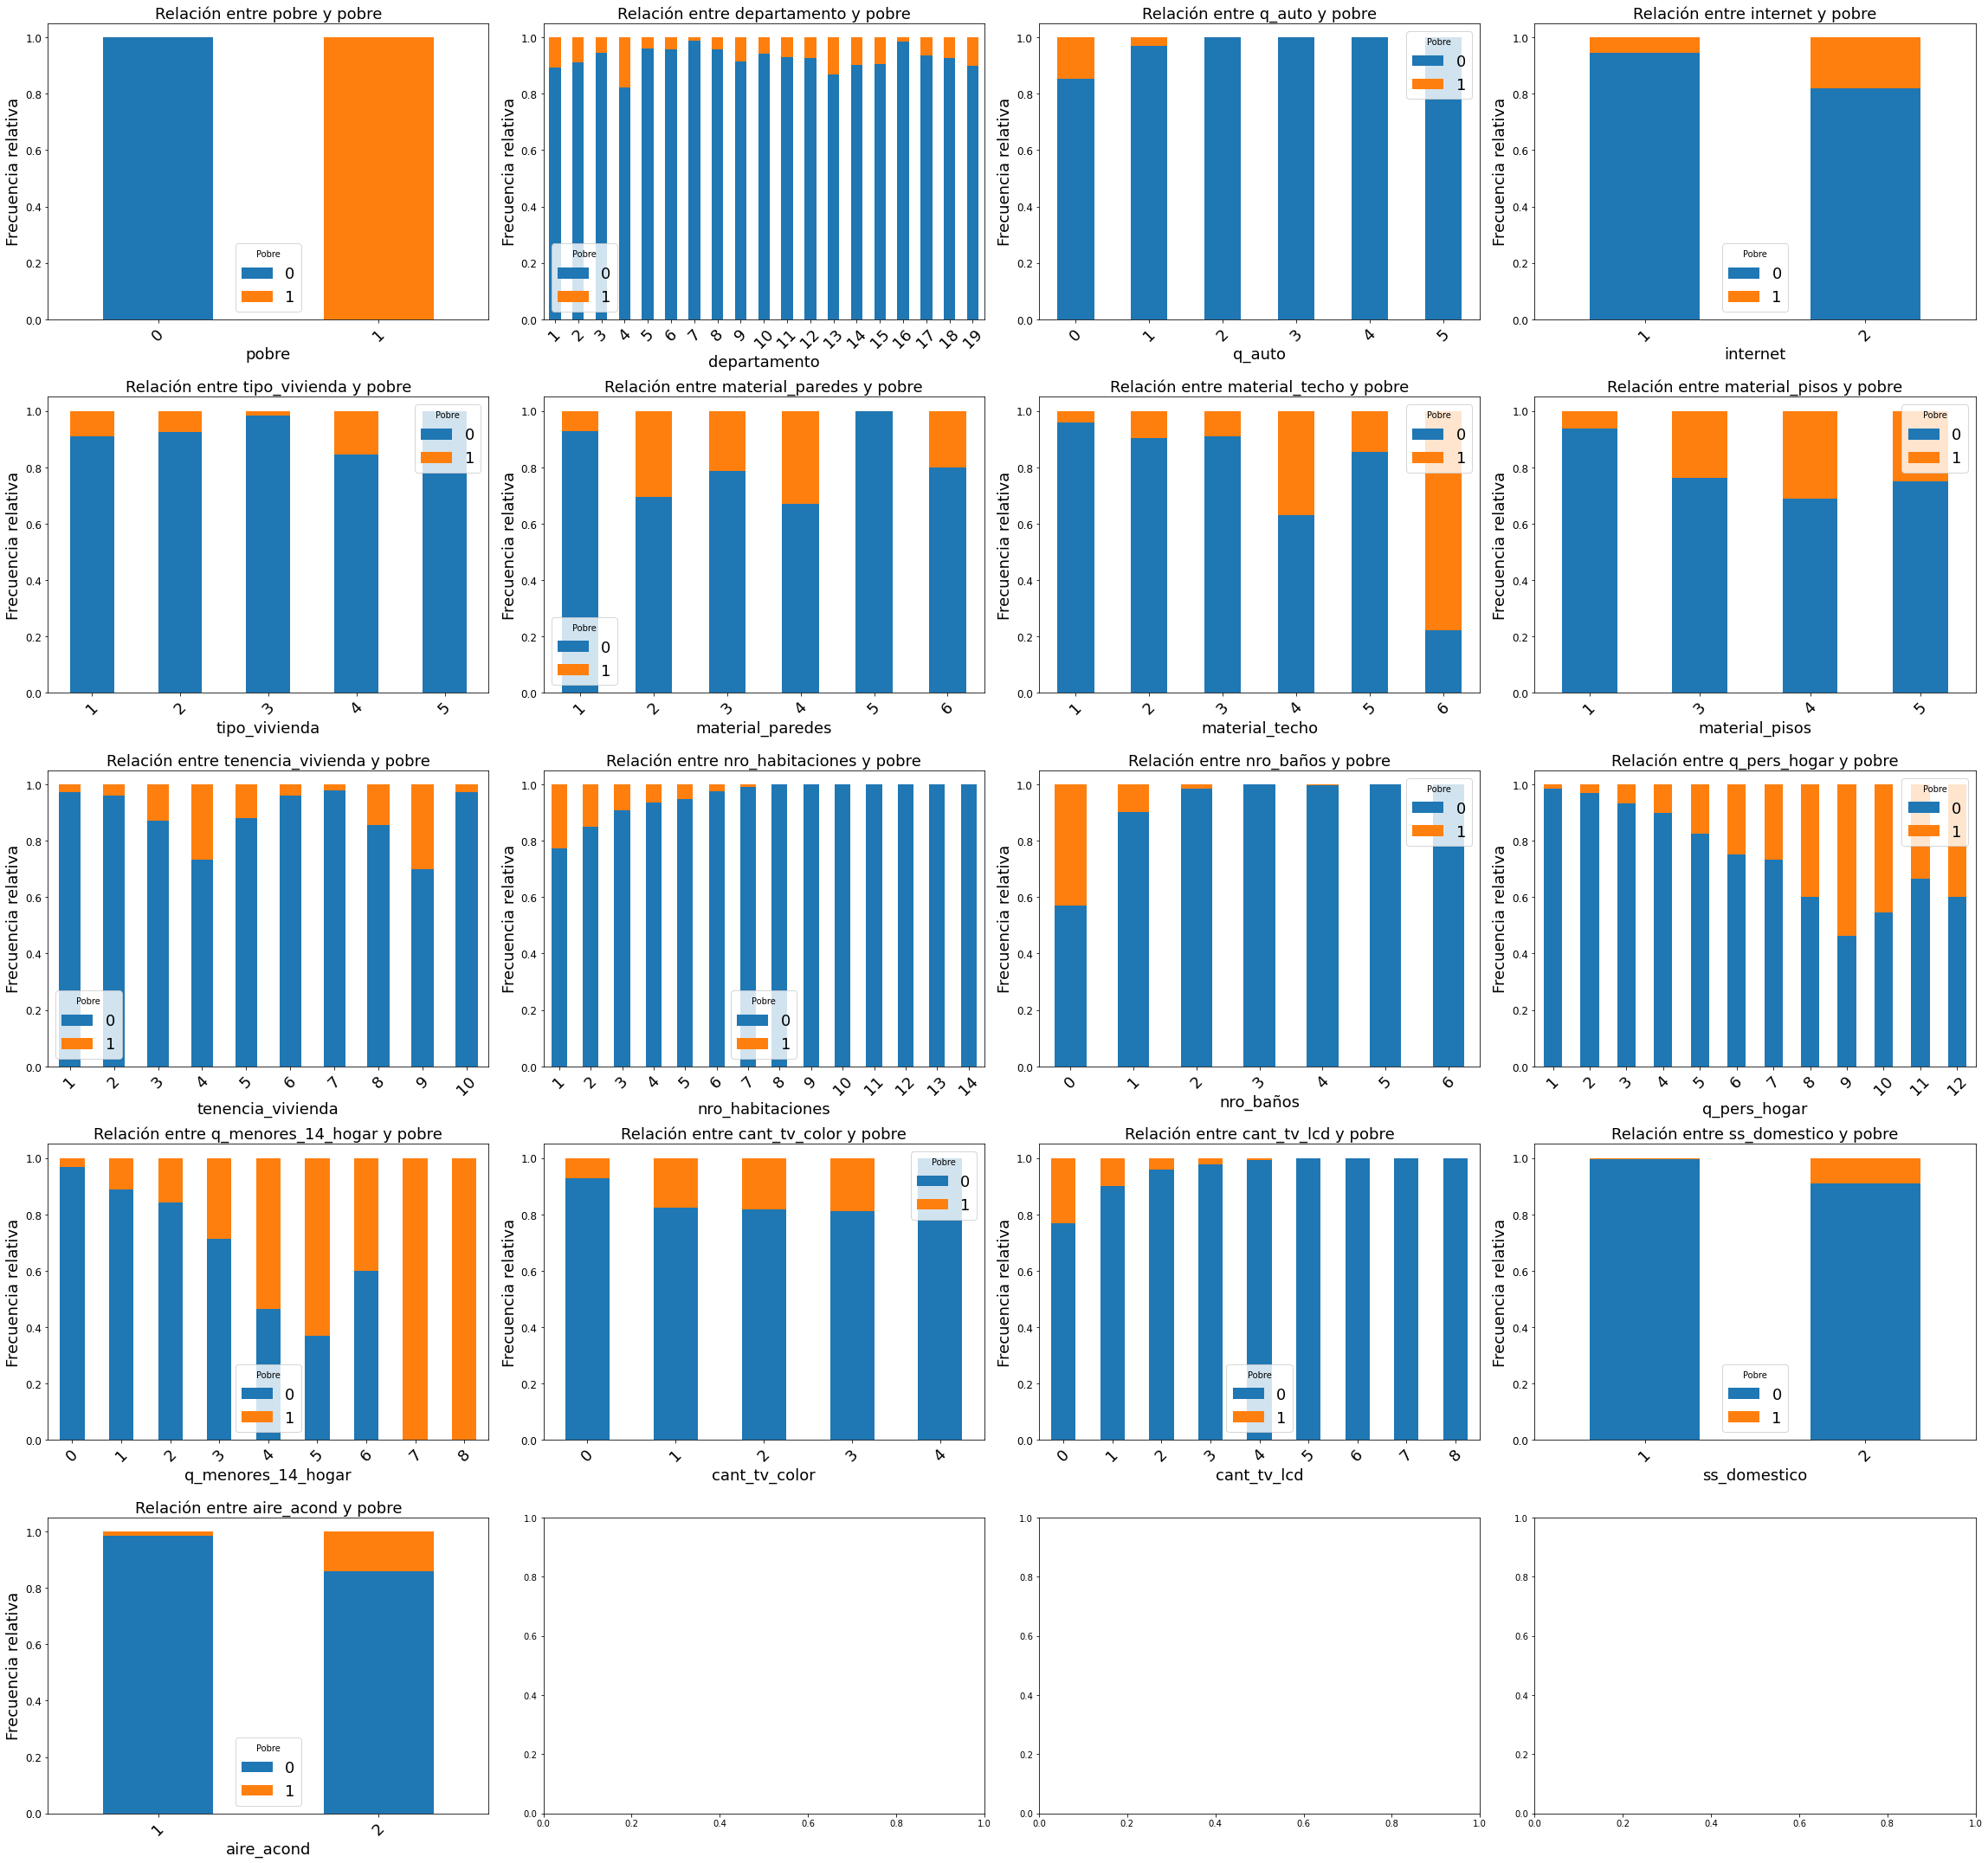

In [280]:
num_rows = 5
num_cols = (len(hogar) + num_rows - 1) // num_rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))

for i, columna in enumerate(hogar):
    row = i // num_cols
    col = i % num_cols

    frecuencias = df.groupby(columna)['pobre'].value_counts(normalize=True).unstack()
    frecuencias.plot(kind='bar', stacked=True, ax=axs[row, col])
    axs[row, col].set_title(f'Relación entre {columna} y pobre', fontsize=18)
    axs[row, col].set_xlabel(columna, fontsize=18)
    axs[row, col].set_ylabel('Frecuencia relativa', fontsize=18)
    axs[row, col].legend(title='Pobre', fontsize=18)
    axs[row, col].tick_params(axis='x', rotation=45, labelsize=18)
    axs[row, col].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

### Interpretación:

**Al graficar las variables asociadas con el hogar en relación con la variable pobreza se encuentran ciertas relaciones que se detallan a continuación.**

departamento: Se observa que hay Departamentos con mayor incidencia de pobreza que otros, en particular Cerro Largo es el Departamento con mayor porcentaje de hogares pobres.

q_auto: la gran mayoría de hogares pobres no poseen automóvil pero se encuentra una pequeña proporción de hogares pobres con tenencia de un automóvil.

internet: la mayor parte de los hogares pobres no tienen acceso a internet, en proporción se podría decir que  solamente 1 de cada 5 hogares pobres posee acceso a este servicio. 

tipo_vivienda: la mayor parte de los hogares pobres son apartamentos en edificios de una planta, en menor proporción se encuentran hogares pobres categorizados como casas y apartamentos o casas en complejos habitacionales.

material_paredes: en cuanto al material de las paredes, se encuentra que la mayor parte de hogares pobres poseen paredes de categoría 4 (Materiales livianos sin revestimiento) y categoría 2 (Ladrillos, ticholos o bloques sin terminación).

material_techo: se encuentra que casi la mitad de los hogares pobres poseen techos de categoría 4 (Liviano sin cielo raso).

material_pisos: los hogares pobres poseen casi que en igual proporción pisos de categoría 3 (Alisado de hormigón), 4 (Solo contrapiso sin piso) y 5 (Tierra sin piso ni contrapiso). 

tenencia_vivienda: la mayor parte de hogares pobres la vemos concentrada en las categorías 4 y 9 que refieren a "Propietario/a solamente de la vivienda y ya la pagó" y "Ocupante sin permiso del propietario/a".

nro_habitaciones: se observa una correlación entre la cantidad de habitaciones y pobreza, a mayor cantidad de habitaciones disminuye la probabilidad de que un hogar sea pobre.

nro_baños: muestra como gran parte de los hogares pobres no poseen baños, existe un pequeño porcentaje de hogares pobres con 1 baño y otro porcentaje aún más pequeño de hogares pobres con 2 baños.

q_pers_hogar: esta variable muestra un crecimiento en hogares pobres a medida que existen mas integrantes en el hogar, se puede ver un crecimiento sostenido de cantidad de hogares pobres hasta la cantidad de 9 integrantes, a partir de hogares con diez integrantes la tendencia empieza a bajar.

q_menores_14_hogar: se puede apreciar como los hogares con menos de 4 hijos menores de 14 años son en su mayoría hogares no-pobres, a partir de hogares con 4 hijos se empiezan a encontrar distribuciones más igualadas entre hogares pobres y no-pobres, y cuando se llega a hogares de 7 o más hijos se encuentran solamente hogares pobres.

cant_tv_color & cant_tv_lcd: Se observa una relación inversa entre ambas variables. A mayor cantidad de tv_lcd, menor incidencia de pobreza. Por otro lado, si se observa presencia de pobreza en hogares con TV a color.

ss_domestico: se encuentra que casi la totalidad de los hogares pobres no cuentan con servicio doméstico.

aire_acond : se puede apreciar como la gran mayoría de los hogares que poseen aire acondicionado tienden a no ser hogares pobres.

### Análisis de outliers

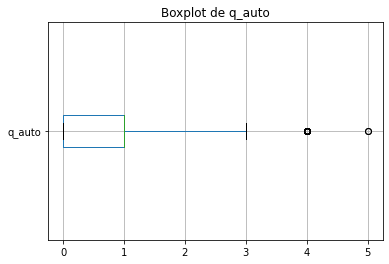

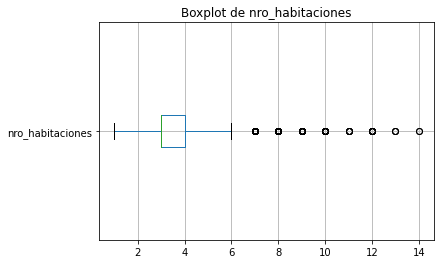

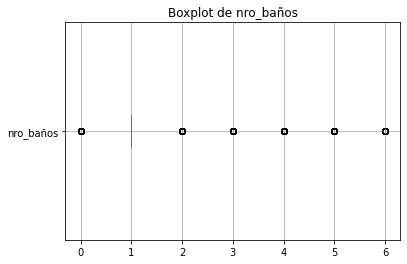

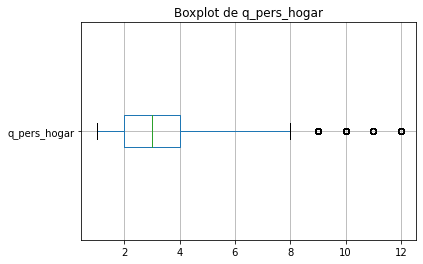

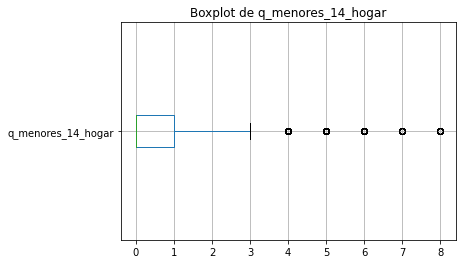

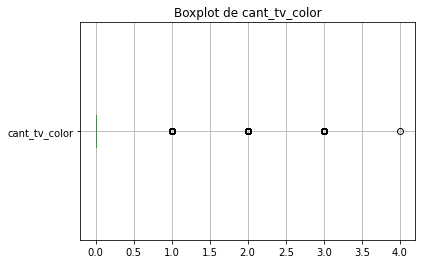

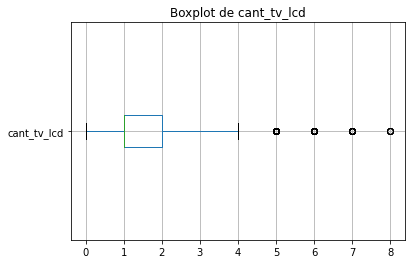

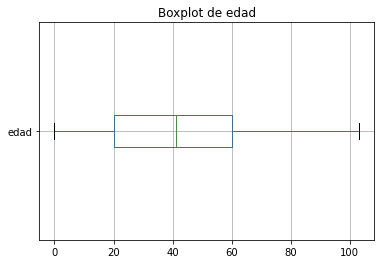

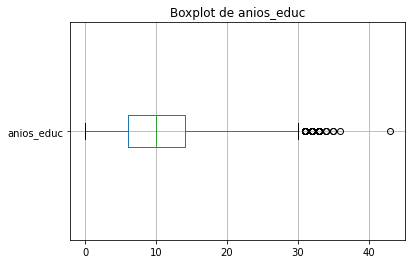

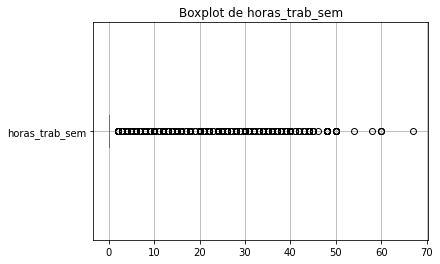

In [281]:
def boxplot_numerical_variables(df):
    numerical_cols = df.select_dtypes(include='number').columns
    numerical_cols=numerical_cols.drop('pobre')
    for col in numerical_cols:
        plt.figure()
        df.boxplot(column=col, vert=False,whis=2)
        plt.title(f'Boxplot de {col}')
        plt.show()
        
boxplot_numerical_variables(df)

#### Q_Autos
Vemos presencia de outliers en casos de hogares con más de 3 autos (4 y 5 autos).
Dado que la media de q_auto es 1, estos valores serían outliers en la base de datos.
En este caso, la decisión de dejar la variable sin modificar se basa en el entendimiento de que estos valores extremos no tendrían un impacto significativo en el modelo o en los resultados obtenidos.

In [282]:
df.q_auto.value_counts(normalize=True)

0    0.483480
1    0.440941
2    0.069149
3    0.005249
4    0.001144
5    0.000036
Name: q_auto, dtype: float64

#### Q_menores_hogar

Dado que el 80% de los hogares en la base de datos contiene menos de 2 menores en el hogar, cualquier hogar con más de 2 menores es un outlier.

Decidimos dejar la variable sin modificaciones ya que es una variable que aporta información relevante al analizar la pobreza. 


In [283]:
df.q_menores_14_hogar.value_counts(normalize=True)

0    0.597693
1    0.213132
2    0.133648
3    0.039706
4    0.011679
5    0.002616
6    0.001090
8    0.000218
7    0.000218
Name: q_menores_14_hogar, dtype: float64

#### Cant_TV_Color

Al analizar los datos concluimos que esta variable se trata de televisores de tecnología antigua, dado que el 87% de los hogares no tiene ninguna.
Por otro lado, esta conclusión surge a partir del análisis de la variable cantidad_tv_lcd.

Dado que la media de Cant_TV_Color es 0, cualquier hogar con 1 TV color o más queda calificado como outlier.

Decidimos dejar la variable sin modificaciones que consideramos que no hay valores extremos que puedan afectar los resultados del modelo.

In [284]:
df.cant_tv_color.value_counts(normalize=True)

0    0.878903
1    0.100282
2    0.019163
3    0.001635
4    0.000018
Name: cant_tv_color, dtype: float64

#### N° Habitaciones

A partir del análisis del boxplot y la relación entre la variable pobreza decidimos topear la variable en 10.
(no hay en la base de datos ningún hogar con 10 habitaciones o más que sea pobre).

In [287]:
df['nro_habitaciones']=np.where(df['nro_habitaciones']>=10,10,df['nro_habitaciones'])

#### Nro Baños

Dado que el 83% de los hogares en la base de datos contiene un único baño, cualquier hogar con más de un baño es un outlier.

Al analizar la distribución de la variable pobre según cantidad de baños, vemos que hay una diferencia entre hogares con 2, 4, 4 y 5 baños.
Por lo tanto decidimos dejar la variable hacer sin modificaciones.

In [285]:
df.nro_baños.value_counts(normalize=True)

1    0.828989
2    0.133012
3    0.027518
4    0.006321
5    0.001907
0    0.001907
6    0.000345
Name: nro_baños, dtype: float64

#### Q_pers_hogar

Notamos presencia de outliers en hogares con más de 8 personas.
Consideramos que si bien es un dato atípico en la base de datos, no es un dato extremo que tendría un impacto significativo en el modelo, por lo cual dejamos la variable sin modificaciones.

#### Edad

No hay outliers en esta variable.

#### Años de educación

Se observa presencia de outliers en personas con más de 30 años de educación.

Consideramos que no es un dato extremo que tendría un impacto significativo en el modelo, por lo cual dejamos la variable sin modificaciones.

#### Horas trab

A partir de analizar el boxplot decidimos no utilizar esta variable dado que tiene mucha variabilidad.

#### Cant_TV LCD

A partir del análisis del boxplot y la relación entre la variable pobreza decidimos topear la variable en 6. (no hay en la base de datos ningún hogar con 6 o más  TV LCD o más que sea pobre).

In [257]:
df.cant_tv_lcd.value_counts(normalize=True)

1    0.435982
2    0.311870
0    0.112397
3    0.108292
4    0.025102
5    0.004904
6    0.001453
Name: cant_tv_lcd, dtype: float64

In [286]:
df['cant_tv_lcd']=np.where(df['cant_tv_lcd']>=6,6,df['cant_tv_lcd'])

## Variables socio-demográficas

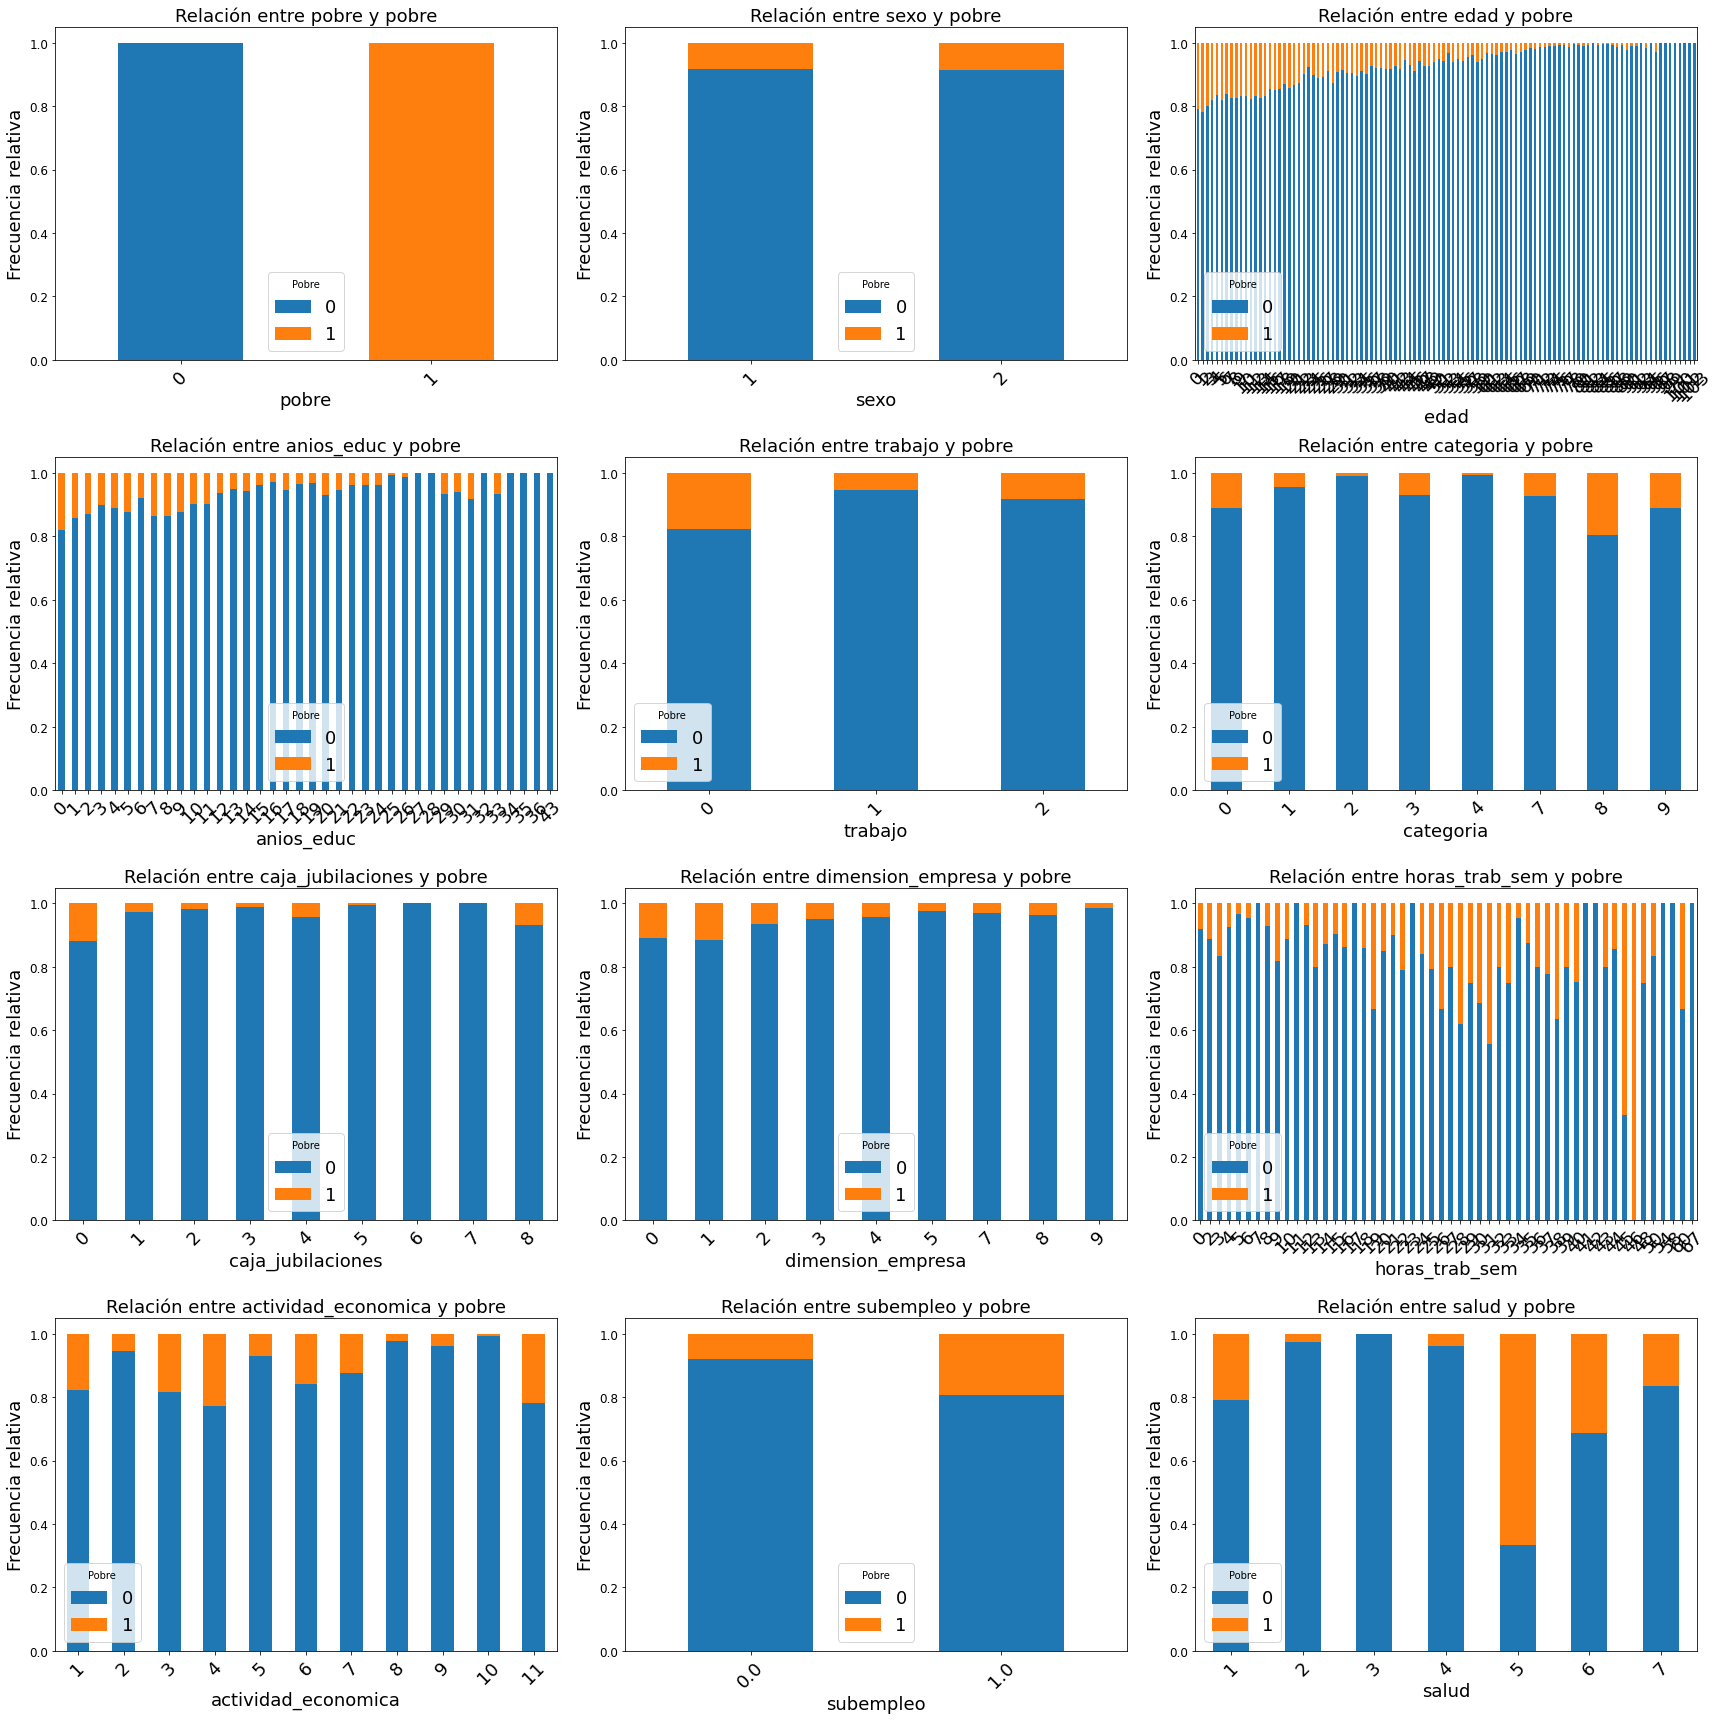

In [288]:
num_rows = 4
num_cols = (len(socio_demograficas) + num_rows - 1) // num_rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))

for i, columna in enumerate(socio_demograficas):
    row = i // num_cols
    col = i % num_cols

    frecuencias = df.groupby(columna)['pobre'].value_counts(normalize=True).unstack()
    frecuencias.plot(kind='bar', stacked=True, ax=axs[row, col])
    axs[row, col].set_title(f'Relación entre {columna} y pobre', fontsize=18)
    axs[row, col].set_xlabel(columna, fontsize=18)
    axs[row, col].set_ylabel('Frecuencia relativa', fontsize=18)
    axs[row, col].legend(title='Pobre', fontsize=18)
    axs[row, col].tick_params(axis='x', rotation=45, labelsize=18)
    axs[row, col].tick_params(axis='y', labelsize=12)

# Ajustar el espaciado entre los subplots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.tight_layout()
plt.show()

### Interpretación:

**Al graficar las variables socio-demograficas en relación con la variable pobreza se encuentran ciertas relaciones que se detallan a continuación.**

sexo: se encuentra una pequeña cantidad mayor de mujeres que de hombres en hogares pobres.

edad: la variable muestra que los hogares pobres poseen gran cantidad de integrantes menores de edad.

anios_educ: si bien la mayor parte de hogares pobres no poseen años de educación registrados, se puede encontrar una porción importante de hogares pobres con hasta 8 y 9 años de educación formal.

trabajo: la menor proporción de hogares pobres se encuentra en la categoría la cual refiere a "Personas que trabajaron la semana anterior".

categoria: refiere a la categoría ocupacional, el mayor volumen de hogares pobres se encuentra en la categoría 8 que refiere a "Trabajador/a de un programa social de empleo".

caja_jubilaciones: la mayor cantidad de hogares pobres no tiene registros de aportes a caja de jubilaciones.

dimensión_empresa: en general las personas que viven en hogares y tienen actividad laboral, trabajan en empresas pequeñas.

actividad_economica: gran proporción de los hogares pobres se encuentran en las categorías 3 (Desocupados buscan trabajo por primera vez), 4 (Desocupados propiamente dichos), y 11 (Inactivo, otro).

subempleo:

salud: la mayor parte de hogares pobres tienen acceso a servicios relacionados con la salud en area de salud del BPS y policlinicas municipales.

### Generamos variables que agrupen los datos a nivel hogar

Dado que todos los integrantes de un mismo hogar son clasificados de la misma manera, consideramos más adecuado tener variables que resuman la información de todos los integrantes de forma unficada.


Por ejemplo: considerando la variable educación, en lugar de mostrar los años de educación de cada individuo del hogar, se plantea la variable en términos de la educación máxima de todos los miembros del hogar.


In [289]:
df['trabajo'].value_counts()

2    23304
1    23223
0     8528
Name: trabajo, dtype: int64

#### Trabajo: 

 0 - Menores de 14 años
 
 1 - Personas que trabajaron la semana anterior
 
 2 - Personas que no trabajaron la semana anterior
 
 Mapeamos el 0 y el 2 como "No trabajo la semana anterior"

In [293]:
df['trabajo'] = df['trabajo'].replace(2, 0)
df['trabajo']=df['trabajo'].astype(int)

In [294]:
df['max_educ_hogar'] =df.groupby('id_hogar')['anios_educ'].transform('max')
df['q_personas_trabajo_hogar'] =df.groupby('id_hogar')['trabajo'].transform('sum')
df['porc_trabaja_hogar'] = df['q_personas_trabajo_hogar']/df['q_pers_hogar']
df['horas_trab_sem_hogar'] =df.groupby('id_hogar')['horas_trab_sem'].transform('sum')
df['porc_menores_hogar']=df['q_menores_14_hogar']/df['q_pers_hogar']

#### Categoría ocupacional: 
Aplicamos la función dummies para mapear a todos los miembros del hogar

In [295]:
dummies = pd.get_dummies(df['categoria'], prefix='categoria', drop_first=True)
df = pd.concat([df, dummies], axis=1)

In [296]:
df['max_educ_hogar'] =df.groupby('id_hogar')['anios_educ'].transform('max')

In [297]:
df.head()

,id_hogar,id_per,pobre,id,departamento,q_auto,internet,tipo_vivienda,material_paredes,material_techo,...,porc_trabaja_hogar,horas_trab_sem_hogar,porc_menores_hogar,categoria_1,categoria_2,categoria_3,categoria_4,categoria_7,categoria_8,categoria_9
0,11558,1,0,11558_1,1,0,1,3,1,1,...,0.0,0,0.0,0,0,0,0,0,0,0
1,11559,1,0,11559_1,1,1,1,3,1,1,...,0.0,0,0.0,1,0,0,0,0,0,0
2,11559,2,0,11559_2,1,1,1,3,1,1,...,0.0,0,0.0,1,0,0,0,0,0,0
3,11560,1,0,11560_1,1,1,1,3,1,1,...,1.0,0,0.0,1,0,0,0,0,0,0
4,11561,1,0,11561_1,1,1,1,3,1,1,...,1.0,0,0.0,0,0,0,0,0,0,1


#### Salud

In [298]:
df['salud'].value_counts()

2    33079
1    17327
4     2296
3     1691
7      643
6       16
5        3
Name: salud, dtype: int64

Con el objetivo de simplificar a la variable salud, mapeamos a las personas que:

Se atienden en área de salud de BPS (5)

Se atienen en Policlínica Municipal (6)

Con categoría 1-"MSP / ASSE"

In [299]:
df['salud'] = df['salud'].replace(6, 1)
df['salud'] = df['salud'].replace(5, 1)

In [300]:
df['salud'].value_counts(normalize=True)

2    0.600836
1    0.315067
4    0.041704
3    0.030715
7    0.011679
Name: salud, dtype: float64

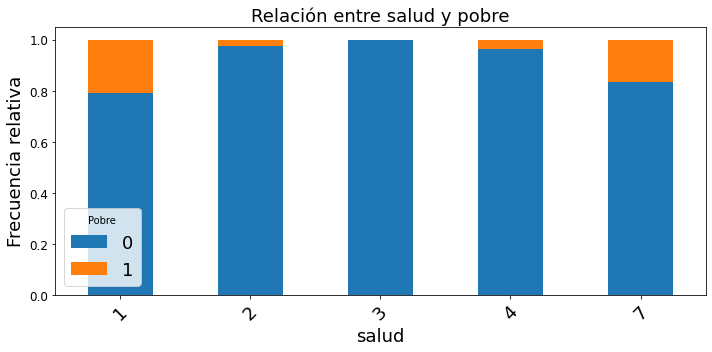

In [301]:
# Definir número de filas y columnas para el gráfico de subplots
num_rows = 1
num_cols = 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5))

for i, columna in enumerate(['salud']):
    row = i // num_cols
    col = i % num_cols

    frecuencias = df.groupby(columna)['pobre'].value_counts(normalize=True).unstack()
    frecuencias.plot(kind='bar', stacked=True, ax=axs)
    axs.set_title(f'Relación entre {columna} y pobre', fontsize=18)
    axs.set_xlabel(columna, fontsize=18)
    axs.set_ylabel('Frecuencia relativa', fontsize=18)
    axs.legend(title='Pobre', fontsize=18)
    axs.tick_params(axis='x', rotation=45, labelsize=18)
    axs.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

In [302]:
dummies = pd.get_dummies(df['salud'], prefix='salud', drop_first=True)
df = pd.concat([df, dummies], axis=1)

#### Jubilados, pensionistas, rentistas

Generamos nuevas columnas para indicar la presencia de algún jubilado/pensionista/rentista en el hogar

In [303]:
#Reemplazamos los valores "2" por "0" (para unificar los negativos)
df['jubilado'] = df['jubilado'].replace(2, 0)
df['pensionista'] = df['pensionista'].replace(2, 0)
df['rentista'] = df['rentista'].replace(2, 0)

In [304]:
dummies = pd.get_dummies(df['jubilado'], prefix='jubilado', drop_first=True)
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['pensionista'], prefix='pensionista', drop_first=True)
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['rentista'], prefix='rentista', drop_first=True)
df = pd.concat([df, dummies], axis=1)

#### Educación

Nos quedamos con el máximo de años de educación alcanzado considerando todos los miembros del hogar

In [46]:
df['max_educ_hogar'] =df.groupby('id_hogar')['anios_educ'].transform('max')

#### Servicio doméstico

Modificamos valores dejandolos de la siguiente forma: 0 = No tiene, 1 = Tiene

In [305]:
df['ss_domestico']= df['ss_domestico'].replace(2, 0)

Procedemos a eliminar las columnas transformadas que yo no vamos a necesitar.

In [306]:
col_a_eliminar=['id_hogar','id_per','sexo','edad','anios_educ','trabajo','categoria','caja_jubilaciones','dimension_empresa','horas_trab_sem',
         'jubilado','pensionista','rentista','actividad_economica','subempleo','salud',  'q_personas_trabajo_hogar']
df_final = df.drop(col_a_eliminar, axis=1) 

In [307]:
df_final = df_final.set_index("id")

In [308]:
df_final.columns

Index(['pobre', 'departamento', 'q_auto', 'internet', 'tipo_vivienda',
       'material_paredes', 'material_techo', 'material_pisos',
       'tenencia_vivienda', 'nro_habitaciones', 'nro_baños', 'q_pers_hogar',
       'q_menores_14_hogar', 'cant_tv_color', 'cant_tv_lcd', 'ss_domestico',
       'aire_acond', 'max_educ_hogar', 'porc_trabaja_hogar',
       'horas_trab_sem_hogar', 'porc_menores_hogar', 'categoria_1',
       'categoria_2', 'categoria_3', 'categoria_4', 'categoria_7',
       'categoria_8', 'categoria_9', 'salud_2', 'salud_3', 'salud_4',
       'salud_7', 'jubilado_1', 'pensionista_1', 'rentista_1'],
      dtype='object')

In [309]:
socio_demograficas2 = ['max_educ_hogar', 'porc_trabaja_hogar', 'horas_trab_sem_hogar', 'categoria_1', 'categoria_2', 'categoria_3', 'categoria_4', 'categoria_8', 'categoria_9', 'salud_2', 'salud_3', 'salud_4', 'salud_7', 'jubilado_1', 'pensionista_1', 'rentista_1']

## Correlación de variables predictoras

### Mapa de correlaciones entre variables socio demográficas

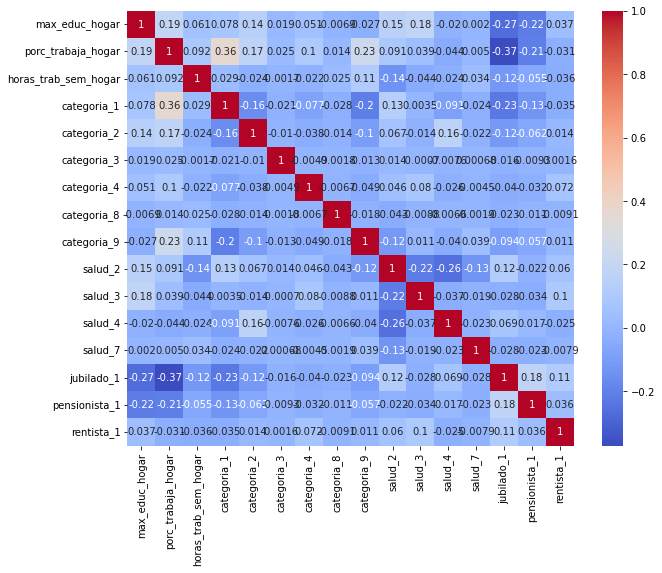

In [311]:
corr = df_final[socio_demograficas2].corr()

fig, ax = plt.subplots(figsize=(10, 8))  # Ajusta el tamaño del gráfico

sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

plt.show()

### Mapa de correlaciones entre variables relacionadas al hogar

In [312]:
hogar

['pobre',
 'departamento',
 'q_auto',
 'internet',
 'tipo_vivienda',
 'material_paredes',
 'material_techo',
 'material_pisos',
 'tenencia_vivienda',
 'nro_habitaciones',
 'nro_baños',
 'q_pers_hogar',
 'q_menores_14_hogar',
 'cant_tv_color',
 'cant_tv_lcd',
 'ss_domestico',
 'aire_acond']

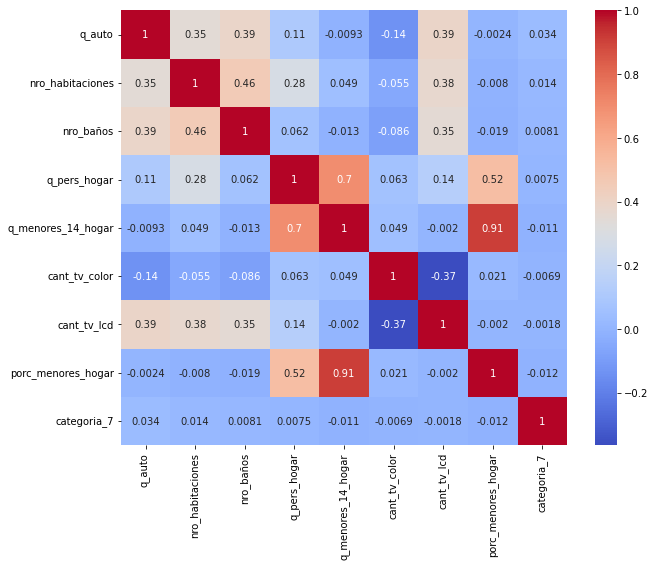

In [313]:
hogar = df_final.columns.drop(['pobre'] + socio_demograficas2).tolist()

corr = df_final[hogar].corr()

fig, ax = plt.subplots(figsize=(10, 8))  # Ajusta el tamaño del gráfico

sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

plt.show()

Al realizar los mapas de correlación entre variables predictoras encontramos que algunas variables tienen un alto nivel de correlación entre si. Estas variables son:
    
-cantidad de personas en el hogar

-cantidad de menores de 14 años en el hogar

-porcentaje de menores en el hogar 

Por este motivo se decide eliminar la variable "cantidad de menores de 14 años en el hogar", ya que entendemos que la información que aporta ya se ve reflejada con las variables restantes.

In [314]:
df_final=df_final.drop('q_menores_14_hogar',axis=1)

# Modelos

#### Transformación One-Hot de variables independientes

A continuación aplicamos la codificación one-hot a las variables categoricas: 'departamento', 'tipo_vivienda', 'material_paredes', 'material_techo','material_pisos', 'tenencia_vivienda'.

Realizamos esto con el objetivo de convertir las variables a numéricas binarias ya que beneficia al rendimiento de los modelos a aplicar.

In [315]:
df_oneHot = pd.get_dummies(df_final,
                                columns = ['departamento', 'tipo_vivienda', 'material_paredes', 'material_techo',
                                        'material_pisos', 'tenencia_vivienda'])

df_oneHot.head(10)

,pobre,q_auto,internet,nro_habitaciones,nro_baños,q_pers_hogar,cant_tv_color,cant_tv_lcd,ss_domestico,aire_acond,...,tenencia_vivienda_1,tenencia_vivienda_2,tenencia_vivienda_3,tenencia_vivienda_4,tenencia_vivienda_5,tenencia_vivienda_6,tenencia_vivienda_7,tenencia_vivienda_8,tenencia_vivienda_9,tenencia_vivienda_10
id,,,,,,,,,,,,,,,,,,,,,
11558_1,0,0,1,3,1,1,0,2,0,1,...,0,1,0,0,0,0,0,0,0,0
11559_1,0,1,1,3,1,2,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
11559_2,0,1,1,3,1,2,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
11560_1,0,1,1,2,1,1,0,2,0,1,...,0,1,0,0,0,0,0,0,0,0
11561_1,0,1,1,5,2,1,0,2,0,2,...,0,1,0,0,0,0,0,0,0,0
11562_1,0,0,1,1,1,1,0,1,0,2,...,0,0,0,0,1,0,0,0,0,0
11563_1,0,1,2,2,1,1,0,1,0,2,...,0,0,0,0,1,0,0,0,0,0
11564_1,0,1,1,4,1,5,0,3,1,1,...,1,0,0,0,0,0,0,0,0,0
11564_2,0,1,1,4,1,5,0,3,1,1,...,1,0,0,0,0,0,0,0,0,0


#### Escalado de variables numéricas

Realizamos la normalización de valores, con el objetivo de garantizar que las variables se encuentren en una escala comparable y evitar problemas, como por ejemplo que una varibale con valores elevados tenga un impacto desproporcionado en los modelos.

In [316]:
scaler = MinMaxScaler()
features_to_scale= df_oneHot.select_dtypes(include='int64').columns
features_to_scale = features_to_scale.difference(['pobre'])
df_oneHot[features_to_scale] = scaler.fit_transform(df_oneHot[features_to_scale])

In [317]:
df_oneHot.head()

,pobre,q_auto,internet,nro_habitaciones,nro_baños,q_pers_hogar,cant_tv_color,cant_tv_lcd,ss_domestico,aire_acond,...,tenencia_vivienda_1,tenencia_vivienda_2,tenencia_vivienda_3,tenencia_vivienda_4,tenencia_vivienda_5,tenencia_vivienda_6,tenencia_vivienda_7,tenencia_vivienda_8,tenencia_vivienda_9,tenencia_vivienda_10
id,,,,,,,,,,,,,,,,,,,,,
11558_1,0,0.0,1,0.222222,0.166667,0.000000,0.0,0.333333,0,1,...,0,1,0,0,0,0,0,0,0,0
11559_1,0,0.2,1,0.222222,0.166667,0.090909,0.0,0.166667,0,1,...,0,0,0,0,1,0,0,0,0,0
11559_2,0,0.2,1,0.222222,0.166667,0.090909,0.0,0.166667,0,1,...,0,0,0,0,1,0,0,0,0,0
11560_1,0,0.2,1,0.111111,0.166667,0.000000,0.0,0.333333,0,1,...,0,1,0,0,0,0,0,0,0,0
11561_1,0,0.2,1,0.444444,0.333333,0.000000,0.0,0.333333,0,2,...,0,1,0,0,0,0,0,0,0,0


## Partición del dataset: Train y Test

In [323]:
y = df_oneHot['pobre']
y.head()

id
11558_1    0
11559_1    0
11559_2    0
11560_1    0
11561_1    0
Name: pobre, dtype: int64

In [322]:
x = df_oneHot[df_oneHot.columns.difference(['pobre'])]
x.head()

,aire_acond,cant_tv_color,cant_tv_lcd,categoria_1,categoria_2,categoria_3,categoria_4,categoria_7,categoria_8,categoria_9,...,tenencia_vivienda_5,tenencia_vivienda_6,tenencia_vivienda_7,tenencia_vivienda_8,tenencia_vivienda_9,tipo_vivienda_1,tipo_vivienda_2,tipo_vivienda_3,tipo_vivienda_4,tipo_vivienda_5
id,,,,,,,,,,,,,,,,,,,,,
11558_1,1,0.0,0.333333,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11559_1,1,0.0,0.166667,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
11559_2,1,0.0,0.166667,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
11560_1,1,0.0,0.333333,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11561_1,2,0.0,0.333333,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [324]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                random_state=104, 
                                test_size=0.20, 
                                shuffle=True)

El método `train_test_split` es una función comúnmente utilizada en el aprendizaje automático para dividir un conjunto de datos en conjuntos de entrenamiento y prueba. 

Interpretación de los parámetros utilizados en este método:

- `x`: Conjunto de los datos que se utilizarán para entrenar y probar el modelo.

- `y`: Conjunto de etiquetas o variables dependientes correspondientes a las características en `x`. 

- `random_state`: Es un número entero que se utiliza para establecer la semilla del generador de números aleatorios. Asignar un valor específico a `random_state` implica que la división del conjunto de datos se realice de la misma manera cada vez que se ejecuta el código. Esto es útil para obtener resultados reproducibles.

- `test_size`: Representa el tamaño (proporción) del conjunto de prueba en relación al conjunto de datos completo. Puede ser un número decimal entre 0 y 1, e indica el porcentaje del conjunto de datos que se utilizará para pruebas. En este caso, establecimos el parametro en 0.20, lo que significa que el 20% de los datos se reservará para el conjunto de prueba, mientras que el 80% restante se utilizará para el conjunto de entrenamiento.

- `shuffle`: Es un parámetro booleano que indica si los datos deben ser mezclados antes de dividirlos en conjuntos de entrenamiento y prueba. Si se establece en `True`, los datos se mezclarán aleatoriamente antes de la división. Esto es útil para evitar posibles sesgos si los datos están ordenados de alguna manera. Para nuestro análisis dejamos su valor por defecto, el cual es `True`.

El método `train_test_split` devuelve cuatro conjuntos de datos: `X_train`, `X_test`, `y_train` y `y_test`. Estos conjuntos contienen las características y las etiquetas divididas según los parámetros proporcionados.

`X_train` y `y_train` representan los datos de entrenamiento, que se utilizarán para ajustar el modelo o algoritmo de aprendizaje automático.

`X_test` y `y_test` representan los datos de prueba, que se utilizarán para evaluar el rendimiento del modelo en datos no vistos previamente.

In [325]:
print("Cantidad de observaciones total: {0}".format(len(x)))
print("Cantidad de observaciones en train: {0}".format(len(X_train)))
print("Cantidad de observaciones en test: {0}".format(len(X_test)))

Cantidad de observaciones total: 55055
Cantidad de observaciones en train: 44044
Cantidad de observaciones en test: 11011


## Modelos
A continuación se busca entrenar algunos modelos en el conjunto de entrenamiento y evaluar su rendimiento en el conjunto de prueba.

### 1 - Naïve Bayes

In [326]:
# se define el modelo
modelo_naive_bayes = MultinomialNB()

# se entrena el modelo
modelo_naive_bayes.fit(X_train, y_train)

# predicciones del modelo
y_pred_test_NB = modelo_naive_bayes.predict(X_test)
y_pred_train_NB = modelo_naive_bayes.predict(X_train)

* Error de clasificación (TRAIN)

In [327]:
(y_pred_train_NB != y_train).sum()/y_train.shape[0]

0.09224866043047861

* Error de clasificación (TEST)

In [328]:
(y_pred_test_NB != y_test).sum()/y_test.shape[0]

0.0939060939060939

In [329]:
# Calculo de la matriz de Confusión
matriz_NB = confusion_matrix(y_test, y_pred_test_NB)
print('Matriz de Confusión:')
print(matriz_NB)

Matriz de Confusión:
[[9566  510]
 [ 524  411]]


In [330]:
(matriz_NB[0,1] + matriz_NB[1,0]) / (matriz_NB[0,0] + matriz_NB[0,1] + matriz_NB[1,0] + matriz_NB[1,1])

0.0939060939060939

### 2- Regresion logística

In [331]:
# se define el modelo
regresion_logistica = LogisticRegression(max_iter = 500)

# se entrena el modelo
regresion_logistica.fit(X_train, y_train)

# predicciones del modelo
y_pred_test_RL = regresion_logistica.predict(X_test)
y_pred_train_RL = regresion_logistica.predict(X_train)

Interpretación de los parámetros utilizados en LogisticRegression

max_iter: Este parámetro se utiliza para especificar el número máximo de iteraciones permitidas durante el entrenamiento del modelo de regresión logística. En este caso, se ha establecido en 500, lo que significa que el algoritmo iterará un máximo de 500 veces para encontrar los coeficientes óptimos. Es posible que en algunos casos el modelo no converja en el número máximo de iteraciones y sea necesario ajustar este valor.

* Error de clasificación (TRAIN)

In [332]:
(y_pred_train_RL != y_train).sum()/y_train.shape[0]

0.06191535736990283

* Error de clasificación (TEST)

In [333]:
(y_pred_test_RL != y_test).sum()/y_test.shape[0]

0.06429933702660975

In [334]:
# Calculo de la Matriz de Confusión
matriz_RL = confusion_matrix(y_test, y_pred_test_RL)
print('Matriz de Confusión:')
print(matriz_RL)

Matriz de Confusión:
[[9899  177]
 [ 531  404]]


In [335]:
(matriz_RL[0,1] + matriz_RL[1,0]) / (matriz_RL[0,0] + matriz_RL[0,1] + matriz_RL[1,0] + matriz_RL[1,1])

0.06429933702660975

###  Coeficientes

In [336]:
coeficientes = regresion_logistica.coef_

# Muestra los coeficientes para cada variable independiente
for i, coef in zip(X_train.columns, coeficientes[0]):
    print(f'Variable {i}: {coef}')

Variable aire_acond: 0.6167266543761956
Variable cant_tv_color: -0.7563916694404372
Variable cant_tv_lcd: -2.3484876039877176
Variable categoria_1: -0.4972450133539205
Variable categoria_2: -1.3327362487532763
Variable categoria_3: 0.004882133115400591
Variable categoria_4: -0.7035312629098434
Variable categoria_7: 0.7093591519776616
Variable categoria_8: 0.059140548459292244
Variable categoria_9: 0.34393576473146203
Variable departamento_1: 1.905263748007766
Variable departamento_10: -0.16264988301174124
Variable departamento_11: -0.01489319740372174
Variable departamento_12: -0.3906883029820878
Variable departamento_13: 1.1493558478277823
Variable departamento_14: 0.41155763045170785
Variable departamento_15: -0.28314910980445696
Variable departamento_16: -1.3149210771761943
Variable departamento_17: -0.04706579692361516
Variable departamento_18: -0.17676500239154214
Variable departamento_19: 0.48402027448148316
Variable departamento_2: -0.1593073780148977
Variable departamento_3: -0

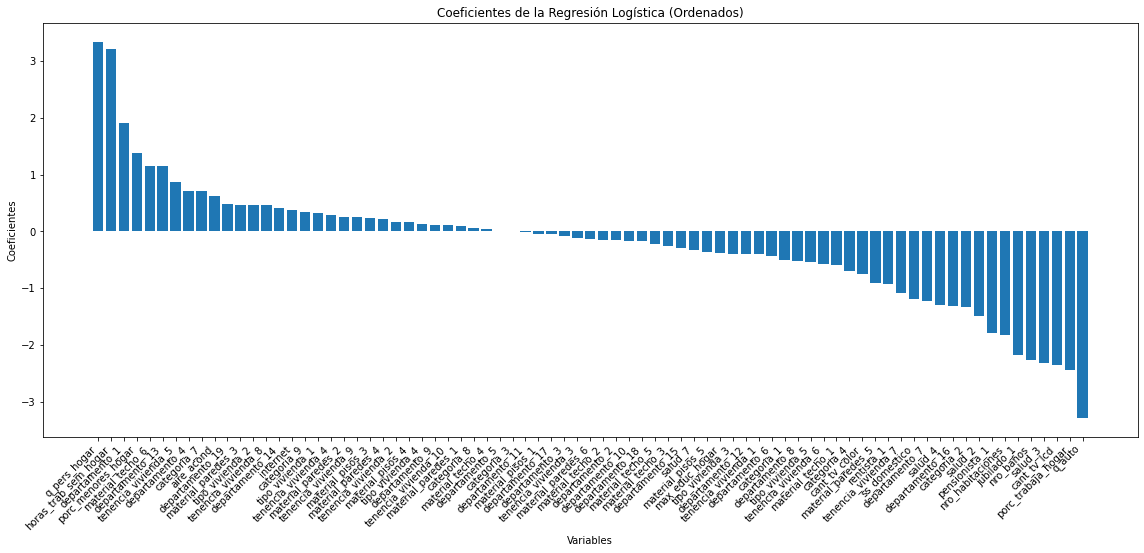

In [407]:
coeficientes = regresion_logistica.coef_[0]
nombres_variables = X_train.columns

coeficientes_ordenados, nombres_ordenados = zip(*sorted(zip(coeficientes, nombres_variables), reverse=True))

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(nombres_ordenados, coeficientes_ordenados)
ax.set_title('Coeficientes de la Regresión Logística (Ordenados)')
ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

### 3- Random Forest

In [338]:
# se define el modelo
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# se entrena el modelo
random_forest.fit(X_train, y_train)

# predicciones del modelo
y_pred_test_RF = random_forest.predict(X_test)
y_pred_train_RF = random_forest.predict(X_train)

* Error de clasificación (TRAIN)

In [339]:
(y_pred_train_RF != y_train).sum()/y_train.shape[0]

0.00011352284079556807

* Error de clasificación (TEST)

In [340]:
(y_pred_test_RF != y_test).sum()/y_test.shape[0]

0.01262373989646717

In [342]:
# Calculo de la Matriz de Confusión
matriz_RF = confusion_matrix(y_test, y_pred_test_RF)
print('Matriz de Confusión:')
print(matriz_RF)

Matriz de Confusión:
[[10070     6]
 [  133   802]]


### 4- XG Boost

Se entrena un modelo XGBoost utilizando los datos de entrenamiento, el mismo realiza predicciones tanto continuas como binarias en los conjuntos de prueba y entrenamiento, y calcula la precisión del modelo utilizando la función `accuracy_score`.

In [343]:
dtrain = xgb.DMatrix(X_train, label=y_train,enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test,enable_categorical=True)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'mae',
    'eta': 0.001,
    'max_depth': 7,
    'seed': 42
}

num_rounds = 500
model = xgb.train(params, dtrain, num_rounds)

y_pred_test_XGB = model.predict(dtest)
y_pred_train_XGB = model.predict(dtrain)

# conversión de las predicciones a valores binarios redondeandos
y_pred_test_binary_XGB = [round(value) for value in y_pred_test_XGB]
y_pred_train_binary_XGB = [round(value) for value in y_pred_train_XGB]

# calculo de la precisión del modelo
accuracy_test_XGB = accuracy_score(y_test, y_pred_test_binary_XGB)
accuracy_train_XGB = accuracy_score(y_train, y_pred_train_binary_XGB)

print(f"Accuracy en el conjunto de prueba: {accuracy_test_XGB}")
print(f"Accuracy en el conjunto de entrenamiento: {accuracy_train_XGB}")

Accuracy en el conjunto de prueba: 0.9388793025156662
Accuracy en el conjunto de entrenamiento: 0.9447370811007174


Interpretación de los parámetros utilizados en XGBoost "Extreme Gradient Boosting":

- `X_train` y `X_test`: Datos de entrenamiento y prueba.

- `y_train` y `y_test`: Etiquetas de entrenamiento y prueba.

- `enable_categorical=True`: Este parámetro se establece en `True` para habilitar el manejo de variables categóricas en XGBoost. Indica que las variables categóricas en los datos de entrada serán tratadas adecuadamente por XGBoost durante el entrenamiento y la predicción.

- `params`: Es un diccionario que contiene los parámetros de configuración para el modelo XGBoost. 
Los parámetros utilizados son:

  - `objective`: Indica la función de objetivo utilizada para el entrenamiento. En este caso, se utiliza 'binary:logistic', que se adapta a problemas de clasificación binaria.
  - `eval_metric`: Especifica la métrica utilizada para evaluar el modelo durante el entrenamiento. En este caso, se utiliza 'mae' (error absoluto medio).
  - `eta`: También conocido como tasa de aprendizaje, controla la contribución de cada árbol al modelo. Un valor más bajo permite un aprendizaje más lento y preciso. En este caso, se establece en 0.001.
  - `max_depth`: Especifica la profundidad máxima de cada árbol en el modelo. Un valor más alto permite que los árboles sean más complejos y se ajusten más a los datos de entrenamiento. Aquí, se establece en 7.
  - `seed`: Es una semilla utilizada para reproducir los resultados. Aquí, se establece en 42.

- `num_rounds`: Indica el número de rondas o iteraciones que se utilizarán para entrenar el modelo. Cada ronda añade un nuevo árbol al modelo. En el presente modelo, se establece en 500.

- `model = xgb.train(params, dtrain, num_rounds)`: Entrena el modelo XGBoost utilizando los parámetros, los datos de entrenamiento `dtrain` y el número de rondas especificado.

- `y_pred_test_XGB` y `y_pred_train_XGB`: Son las predicciones continuas del modelo en los conjuntos de prueba y entrenamiento, respectivamente.

- `y_pred_test_binary_XGB` y `y_pred_train_binary_XGB`: Son las predicciones binarias redondeadas del modelo en los conjuntos de prueba y entrenamiento, respectivamente.

- `accuracy_test_XGB` y `accuracy_train_XGB`: Son las precisiones (accuracies) del modelo en los conjuntos de prueba y entrenamiento, respectivamente.

In [344]:
recall_XGB = recall_score(y_test, y_pred_test_binary_XGB)
print('Recall del modelo: %.3f' % recall_XGB)

Recall del modelo: 0.397


Luego de realizar diferentes pruebas modificando parametros, encontramos que el resultado de recall que arroja el modelo no es tan satisfactorio como el resultado obtenido con los modelos anteriormente planteados.

## Métricas

### Análisis de los resultados
A continuación verificamos como es el modelo utilizando las métricas de los problemas de clasificación, para ello vamos a comenzar obteniendo la matriz de confusión. Para esto importamos del módulo scikitlearn.metrics, confusion_matrix, y aplicamos esta instrucción junto a los datos de prueba y los obtenidos en la predicción realizada previamente. 

### 1- Naive Bayes

In [345]:
# Calculo de la precisión del modelo
precision_NB = precision_score(y_test, y_pred_test_NB)
print('Precisión del modelo: %.3f' % precision_NB)

Precisión del modelo: 0.446


In [346]:
# Calculo de Accuracy del modelo
accuracy_NB = accuracy_score(y_test, y_pred_test_NB)
print('Accuracy del modelo: %.3f' % accuracy_NB)

Accuracy del modelo: 0.906


In [347]:
# Calculo de Recall del modelo
recall_NB = recall_score(y_test, y_pred_test_NB)
print('Recall del modelo: %.3f' % recall_NB)

Recall del modelo: 0.440


In [348]:
# Calculo de F1 score del modelo
f1_NB = f1_score(y_test, y_pred_test_NB)
print('F1 del modelo: %.3f' % f1_NB)

F1 del modelo: 0.443


### 2- Regresión logística

In [349]:
# Calculo de la precisión del modelo
precision_RL = precision_score(y_test, y_pred_test_RL)
print('Precisión del modelo: %.3f' % precision_RL)

Precisión del modelo: 0.695


In [350]:
# Calculo de Accuracy del modelo
accuracy_RL = accuracy_score(y_test, y_pred_test_RL)
print('Accuracy del modelo: %.3f' % accuracy_RL)

Accuracy del modelo: 0.936


In [351]:
#Calculo Recall del modelo
recall_RL = recall_score(y_test, y_pred_test_RL)
print('Recall del modelo: %.3f' % recall_RL)

Recall del modelo: 0.432


In [352]:
# Calculo de F1 score del modelo
f1_RL = f1_score(y_test, y_pred_test_RL)
print('F1 del modelo: %.3f' % f1_RL)

F1 del modelo: 0.533


In [353]:
print('Modelo RL Error Train: %.4f' % mean_squared_error(y_train, y_pred_train_RL))
print('Modelo RL Error Test: %.4f' % mean_squared_error(y_test, y_pred_test_RL))

Modelo RL Error Train: 0.0619
Modelo RL Error Test: 0.0643


Se realiza validación cruzada utilizando el modelo de regresión logística, con 10 divisiones y utilizando el error cuadrático medio negativo como métrica de evaluación. Luego, calculamos el error medio a partir de los resultados de la validación cruzada y se imprime.

In [354]:
cv_rl = cross_val_score(regresion_logistica, X = X_train, y = y_train, cv = 10, scoring='neg_mean_squared_error')
error_cv_rl = -1*np.mean(cv_rl)
print('Model Error CV : %.4f' % error_cv_rl)

Model Error CV : 0.0628


Interpretación de los parámetros:

- `regresion_logistica`: Modelo de regresión logística que se utiliza para el entrenamiento y la validación cruzada.

- `X_train`: Datos de entrenamiento.

- `y_train`: Etiquetas de entrenamiento.

- `cv=10`: Número de divisiones o "folds" utilizados en la validación cruzada. En este caso, se utiliza una validación cruzada con 10 divisiones, lo que significa que los datos se dividirán en 10 partes y se realizarán 10 iteraciones de entrenamiento y evaluación.

- `scoring='neg_mean_squared_error'`: Indica la métrica utilizada para evaluar el rendimiento del modelo durante la validación cruzada. En este caso, se utiliza el error cuadrático medio negativo (`neg_mean_squared_error`), que es una métrica comúnmente utilizada para problemas de regresión. El valor negativo se utiliza porque la función `cross_val_score` busca maximizar el puntaje, pero el error cuadrático medio debe minimizarse.

- `cv_rl`: Es una lista que contiene los resultados de la validación cruzada para cada división. Cada valor en la lista representa el resultado del modelo en una división específica.

- `error_cv_rl`: Es el error medio calculado a partir de los resultados de la validación cruzada. Se utiliza el valor negativo del error cuadrático medio promedio para obtener una representación más intuitiva del rendimiento del modelo.

In [355]:
print('Modelo NB Error Train: %.4f' % mean_squared_error(y_train, y_pred_train_NB))
print('Modelo NB Error Test: %.4f' % mean_squared_error(y_test, y_pred_test_NB))

Modelo NB Error Train: 0.0922
Modelo NB Error Test: 0.0939


In [356]:
cv_nb = cross_val_score(modelo_naive_bayes, X = X_train, y = y_train, cv = 10, scoring='neg_mean_squared_error')
error_cv_nb = -1*np.mean(cv_nb)
print('Model NB Error CV : %.4f' % error_cv_nb)

Model NB Error CV : 0.0924


### 3- Random Forest

In [357]:
# Calculo de la precisión del modelo
precision_RF = precision_score(y_test, y_pred_test_RF)
print('Precisión del modelo: %.3f' % precision_RF)

Precisión del modelo: 0.993


In [358]:
# Calculo de Accuracy del modelo
accuracy_RF = accuracy_score(y_test, y_pred_test_RF)
print('Accuracy del modelo: %.3f' % accuracy_RF)

Accuracy del modelo: 0.987


In [359]:
# Calculo de Recall del modelo
recall_RF = recall_score(y_test, y_pred_test_RF)
print('Recall del modelo: %.3f' % recall_RF)

Recall del modelo: 0.858


In [360]:
# Calculo de F1 score del modelo
f1_RF = f1_score(y_test, y_pred_test_RF)
print('F1 del modelo: %.3f' % f1_RF)

F1 del modelo: 0.920


In [361]:
print('Modelo RF Error Train: %.4f' % mean_squared_error(y_train, y_pred_train_RF))
print('Modelo RF Error Test: %.4f' % mean_squared_error(y_test, y_pred_test_RF))

Modelo RF Error Train: 0.0001
Modelo RF Error Test: 0.0126


Se realiza validación cruzada utilizando el modelo de Random Forest, con 10 divisiones y utilizando el error cuadrático medio negativo como métrica de evaluación. 

Finalmente, se calcula el error medio a partir de los resultados de la validación cruzada y se imprime.

In [362]:
cv_rf = cross_val_score(random_forest, X = X_train, y = y_train, cv = 10, scoring='neg_mean_squared_error')
error_cv_rf = -1*np.mean(cv_rf)
print('Model Error CV : %.4f' % error_cv_rf)

Model Error CV : 0.0135


Interpretación de los parámetros:

- `random_forest`: Es el modelo que se utiliza para el entrenamiento y la validación cruzada.

- `X_train`: Datos de entrenamiento.

- `y_train`: Etiquetas de entrenamiento.

- `cv=10`: Número de divisiones o "folds" utilizados en la validación cruzada. En este caso, los datos se dividirán en 10 partes y se realizarán 10 iteraciones de entrenamiento y evaluación.

- `scoring='neg_mean_squared_error'`: Indica la métrica utilizada para evaluar el rendimiento del modelo durante la validación cruzada. En este caso, se utiliza el error cuadrático medio negativo (`neg_mean_squared_error`), que es una métrica comúnmente utilizada para problemas de regresión. El valor negativo se utiliza porque la función `cross_val_score` busca maximizar el puntaje, pero el error cuadrático medio debe minimizarse.

- `cv_rf`: Es la lista que contiene los resultados de la validación cruzada para cada división. Cada valor en la lista representa el resultado del modelo en una división específica.

- `error_cv_rf`: Es el error medio calculado a partir de los resultados de la validación cruzada. Se utiliza el valor negativo del error cuadrático medio promedio para obtener una representación más intuitiva del rendimiento del modelo.

##### Importancia de variables en modelo Random Forest

A continuación se realiza la representación gráfica de la importancia de cada variable considerada en el modelo.

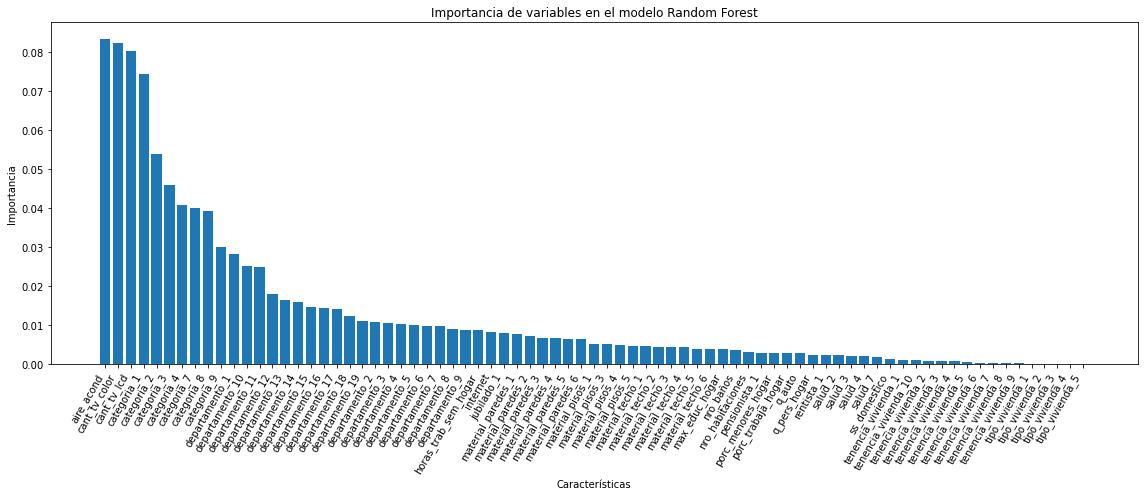

In [409]:
feature_importance = random_forest.feature_importances_
indices_ordenados = np.argsort(feature_importance)[::-1]
feature_importance_ordenada = feature_importance[indices_ordenados]
nombres_variables = X_train.columns

plt.figure(figsize=(16, 7))
plt.bar(range(len(nombres_variables)), feature_importance_ordenada)
plt.xticks(range(len(nombres_variables)), nombres_variables, rotation=60, ha='right')
plt.title('Importancia de variables en el modelo Random Forest')
plt.xlabel('Características')
plt.ylabel('Importancia')

plt.tight_layout()
plt.show()

In [364]:
for i, feature in enumerate(X_train.columns):
    print(f'Característica: {feature} - Importancia: {feature_importance_ordenada[i]}')

Característica: aire_acond - Importancia: 0.0833908627553305
Característica: cant_tv_color - Importancia: 0.08224125200253737
Característica: cant_tv_lcd - Importancia: 0.0801825058203024
Característica: categoria_1 - Importancia: 0.07447022209368381
Característica: categoria_2 - Importancia: 0.05393981791832221
Característica: categoria_3 - Importancia: 0.046036802806141724
Característica: categoria_4 - Importancia: 0.04067861662578094
Característica: categoria_7 - Importancia: 0.040020679975951545
Característica: categoria_8 - Importancia: 0.03934244901981772
Característica: categoria_9 - Importancia: 0.030122047235358874
Característica: departamento_1 - Importancia: 0.028120477766479038
Característica: departamento_10 - Importancia: 0.0251935661810637
Característica: departamento_11 - Importancia: 0.024849787157899646
Característica: departamento_12 - Importancia: 0.017948017131305657
Característica: departamento_13 - Importancia: 0.01644502915395839
Característica: departamento_14 

### Random forest (2)

Con el objetivo de lograr una mejora en la performance del modelo continuamos realizando reducción de variables.

En primer lugar, luego de realizar varias pruebas y analizar la gráfica de Feature Importance, constatamos que eliminar la variable Salud mejora la performance del modelo, por lo cual procedimos a eliminarla del dataset.

Adicionalmente utilizamos el parámetro max_features para establecer un máximo de 57 variables, consideramos este valor luego de realizar pruebas y determinar que es el valor óptimo para alcanzar el objetivo buscado.

In [365]:
columnas_eliminar = [col for col in X_train.columns if 'salud' in col ] 
X_train_2 = X_train.drop(columnas_eliminar, axis=1)
X_test_2 = X_test.drop(columnas_eliminar, axis=1)

In [366]:
random_forest2 = RandomForestClassifier(n_estimators=200, random_state=42, max_features=57)
random_forest2.fit(X_train_2, y_train)

RandomForestClassifier(max_features=57, n_estimators=200, random_state=42)

Interpretación de los Parámetros:

- `n_estimators=200`: Número de árboles que se van a construir en el Random Forest. Se crearán 200 árboles en el modelo.

- `random_state=42`: Se utiliza para establecer una semilla aleatoria y garantizar la reproducibilidad de los resultados. Facilita la comparación de resultados entre diferentes ejecuciones.

- `max_features=57`: Controla la cantidad de características (features) que se consideran al tomar decisiones en cada árbol del Random Forest. Se considerarán 57 características al construir cada árbol.

- `X_train2`: Datos de entrenamiento. 

- `y_train`: Etiquetas de entrenamiento. 

In [367]:
y_pred_test_RF2 = random_forest2.predict(X_test_2)
y_pred_train_RF2 = random_forest2.predict(X_train_2)

In [368]:
# Calculo de la precisión del modelo
precision_RF2 = precision_score(y_test, y_pred_test_RF2)
print('Precisión del modelo RF2: %.3f' % precision_RF2)

Precisión del modelo RF2: 0.984


In [369]:
# Calculo de Accuracy del modelo
accuracy_RF2 = accuracy_score(y_test, y_pred_test_RF2)
print('Accuracy del modelo RF2: %.3f' % accuracy_RF2)

Accuracy del modelo RF2: 0.992


In [370]:
# Calculo de Recall del modelo
recall_RF2 = recall_score(y_test, y_pred_test_RF2)
print('Recall del modelo: %.3f' % recall_RF2)

Recall del modelo: 0.920


In [371]:
# Calculo de F1 score del modelo
f1_RF2 = f1_score(y_test, y_pred_test_RF2)
print('F1 del modelo: %.3f' % f1_RF2)

F1 del modelo: 0.951


In [372]:
print('Modelo RF Error Train: %.4f' % mean_squared_error(y_train, y_pred_train_RF2))
print('Modelo RF Error Test: %.4f' % mean_squared_error(y_test, y_pred_test_RF2))

Modelo RF Error Train: 0.0002
Modelo RF Error Test: 0.0081


### Random Forest (3)

Se crea un clasificador Random Forest con 200 árboles, se establece una semilla aleatoria de 42 para reproducibilidad, se consideran 57 características al tomar decisiones en cada árbol y se utiliza el esquema de ponderación equilibrado para las clases durante el entrenamiento. Luego, se ajusta el modelo a los datos de entrenamiento `X_train2` y `y_train`.
Adicionalmente realizamos una prueba de modelado con un balanceo de los datos.

In [373]:
random_forest3 = RandomForestClassifier(n_estimators=200, random_state=42, max_features=57,class_weight='balanced_subsample')
random_forest3.fit(X_train_2, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_features=57,
                       n_estimators=200, random_state=42)

Interpretación de los parámetros:

- `class_weight='balanced_subsample'`: Permite ajustar el peso de las clases en el modelo de Random Forest. Al establecerlo en `'balanced_subsample'`, se asignará automáticamente un peso equilibrado a las clases durante el entrenamiento. Esto es útil cuando las clases están desequilibradas en términos de su distribución en los datos de entrenamiento. El algoritmo asignará pesos más altos a las clases minoritarias para compensar su menor representación y garantizar un aprendizaje equilibrado.

In [374]:
y_pred_test_RF3 = random_forest3.predict(X_test_2)
y_pred_train_RF3 = random_forest3.predict(X_train_2)

In [375]:
# Calculo de la precisión del modelo
precision_RF3 = precision_score(y_test, y_pred_test_RF3)
print('Precisión del modelo RF2: %.3f' % precision_RF3)

Precisión del modelo RF2: 0.983


In [376]:
# Calculo de Accuracy del modelo
accuracy_RF3 = accuracy_score(y_test, y_pred_test_RF3)
print('Accuracy del modelo RF2: %.3f' % accuracy_RF3)

Accuracy del modelo RF2: 0.991


In [377]:
# Calculo de Recall del modelo
recall_RF3 = recall_score(y_test, y_pred_test_RF3)
print('Recall del modelo: %.3f' % recall_RF3)

Recall del modelo: 0.907


In [378]:
# Calculo de F1 score del modelo
f1_RF3 = f1_score(y_test, y_pred_test_RF3)
print('F1 del modelo: %.3f' % f1_RF3)

F1 del modelo: 0.943


In [379]:
print('Modelo RF Error Train: %.4f' % mean_squared_error(y_train, y_pred_train_RF3))
print('Modelo RF Error Test: %.4f' % mean_squared_error(y_test, y_pred_test_RF3))

Modelo RF Error Train: 0.0002
Modelo RF Error Test: 0.0093


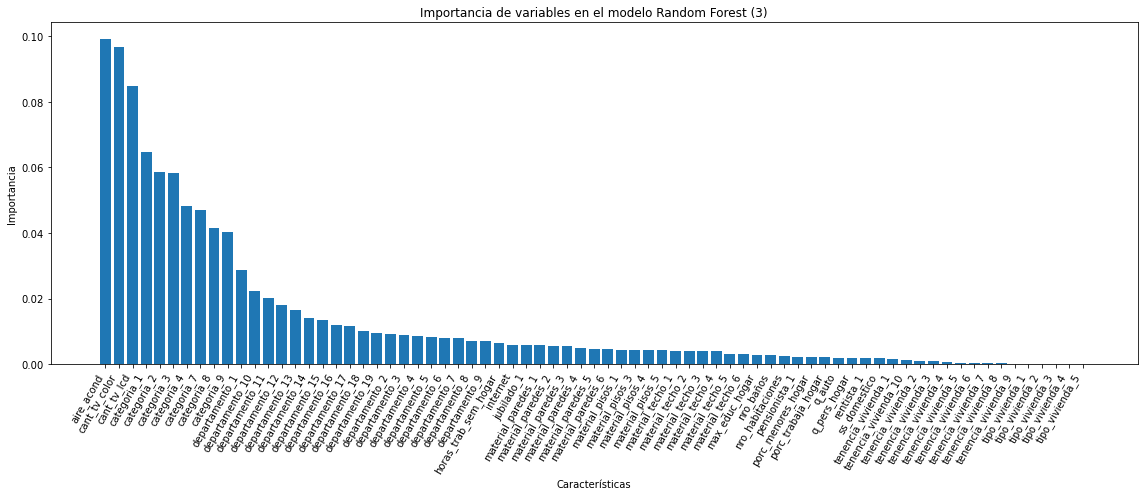

In [410]:
num_features = 57  

feature_importance = random_forest2.feature_importances_
indices_ordenados = np.argsort(feature_importance)[::-1]
feature_importance_ordenada = feature_importance[indices_ordenados]
nombres_variables = X_train_2.columns

plt.figure(figsize=(16, 7))
plt.bar(range(len(nombres_variables)), feature_importance_ordenada)
plt.xticks(range(len(nombres_variables)), nombres_variables, rotation=60, ha='right')
plt.title('Importancia de variables en el modelo Random Forest (3)')
plt.xlabel('Características')
plt.ylabel('Importancia')

plt.tight_layout()
plt.show()

In [411]:
for i, feature in enumerate(X_train_2.columns):
    if(i<72):
        print(f'Característica: {feature} - Importancia: {feature_importance_ordenada[i]}')

Característica: aire_acond - Importancia: 0.0992090138938593
Característica: cant_tv_color - Importancia: 0.09658255070480848
Característica: cant_tv_lcd - Importancia: 0.08486827257740873
Característica: categoria_1 - Importancia: 0.06458301081327913
Característica: categoria_2 - Importancia: 0.058607239203391844
Característica: categoria_3 - Importancia: 0.058159018798303465
Característica: categoria_4 - Importancia: 0.04820568066772408
Característica: categoria_7 - Importancia: 0.04692690494252514
Característica: categoria_8 - Importancia: 0.041526554759350534
Característica: categoria_9 - Importancia: 0.04025723908164574
Característica: departamento_1 - Importancia: 0.02875778699459544
Característica: departamento_10 - Importancia: 0.02227336537596408
Característica: departamento_11 - Importancia: 0.020312060874254852
Característica: departamento_12 - Importancia: 0.018115309055467505
Característica: departamento_13 - Importancia: 0.016613250526566953
Característica: departamento_1

### Comparación

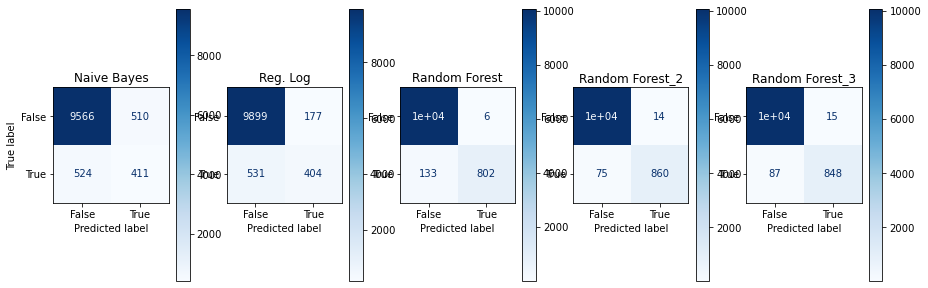

In [382]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax[0].set_title("Naive Bayes")
ax[1].set_title("Reg. Log")
ax[2].set_title("Random Forest")
ax[3].set_title("Random Forest_2")
ax[4].set_title("Random Forest_3")

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(y_test, y_pred_test_NB),
    display_labels=[False, True]).plot(ax=ax[0], cmap='Blues')

metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_test_RL),
    display_labels=[False, True]).plot(ax=ax[1], cmap='Blues')

metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_test_RF),
    display_labels=[False, True]).plot(ax=ax[2], cmap='Blues')

metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_test_RF2),
    display_labels=[False, True]).plot(ax=ax[3], cmap='Blues')

metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_test_RF3),
    display_labels=[False, True]).plot(ax=ax[4], cmap='Blues')

plt.show()

## Resumen

In [383]:
resultados_NB = []
resultados_RL = []
resultados_RF = []
resultados_RF2 = []
resultados_RF3 = []


resultados_NB.append(precision_NB)
resultados_NB.append(accuracy_NB)
resultados_NB.append(recall_NB)
resultados_NB.append(f1_NB)

resultados_RL.append(precision_RL)
resultados_RL.append(accuracy_RL)
resultados_RL.append(recall_RL)
resultados_RL.append(f1_RL)

resultados_RF.append(precision_RF)
resultados_RF.append(accuracy_RF)
resultados_RF.append(recall_RF)
resultados_RF.append(f1_RF)

resultados_RF2.append(precision_RF2)
resultados_RF2.append(accuracy_RF2)
resultados_RF2.append(recall_RF2)
resultados_RF2.append(f1_RF2)

resultados_RF3.append(precision_RF3)
resultados_RF3.append(accuracy_RF3)
resultados_RF3.append(recall_RF3)
resultados_RF3.append(f1_RF3)

In [384]:
resultados = pd.DataFrame(
    {'Resultados NB': resultados_NB,
     'Resultados RL': resultados_RL,
     'Resultados RF': resultados_RF,
     'Resultados RF2': resultados_RF2,
     'Resultados RF3': resultados_RF3
    })

resultados = resultados.rename(index={0: 'precision', 1: 'accuracy', 2: 'recall', 3: 'f1'})

In [385]:
resultados

,Resultados NB,Resultados RL,Resultados RF,Resultados RF2,Resultados RF3
precision,0.446254,0.695353,0.992574,0.983982,0.982619
accuracy,0.906094,0.935701,0.987376,0.991917,0.990737
recall,0.439572,0.432086,0.857754,0.919786,0.906952
f1,0.442888,0.532982,0.920252,0.950802,0.943270


Consideramos que el mejor de los modelos testeados es Random Forest 2, particularmente porque performa mejor que el resto Recall y f1.

En cuanto a precision performa levemente inferior al modelo Random Forest original, pero consideramos que aun asi es mejor el modelo RF original dado que:

1-Contiene menor cantidad de variables (57 vs 72), por lo tanto serian menos las preguntas a realizar en una eventual encuesta. Por otro lado esto nos ayuda a prevenir overfitting y que los resultados generalicen mejor ante datos nuevos.

2- Por otro lado creemos que el modelo RF2 es el mejor principalmente debido a que tiene el mayor indicador de Recall y f1.
Mejor performance en Recall: El modelo tiene la menor tasa de falsos negativos, es decir mayor sensibilidad para detectar a las personas pobres, y por lo tanto menos probabilidades de pasar por alto a las personas que realmente necesitan asistencia.

Mejor performance en f1: El valor de F1 es una métrica que combina la precisión y la exhaustividad del modelo, lo cual es especialmente relevante cuando las clases están desequilibradas en términos de su distribución en los datos (como es el caso de este dataset). La precisión representa la capacidad del modelo para predecir correctamente los hogares pobres, mientras que el recall mide la capacidad del modelo para capturar todos los hogares pobres presentes en los datos. Al combinar estas dos medidas, el valor de F1 proporciona una evaluación balanceada del rendimiento del modelo.


## Stacking
#### Meta Model RF (2)

El meta-modelo es otro clasificador Random Forest que se utiliza en un contexto específico, como en técnicas de ensamblaje o apilamiento (stacking). En este caso, se utiliza para combinar y aprovechar las predicciones de los modelos base anteriores.

El objetivo es mejorar la precisión general del modelo al combinar las fortalezas de diferentes modelos base.

In [386]:
from sklearn.ensemble import StackingClassifier

# se define el meta-modelo
meta_model =  RandomForestClassifier(n_estimators=100, random_state=42)

# se define el modelo de stacking
model_stacking = StackingClassifier(
    estimators=[('rf', random_forest2), ('nb', modelo_naive_bayes), ('lr', regresion_logistica)],
    final_estimator=meta_model
)

# se entrena el modelo de stacking
model_stacking.fit(X_train, y_train)

# se realizan predicciones en el conjunto de prueba
y_pred = model_stacking.predict(X_test)

# calculo de la precisión de las predicciones
precision_ST_RF = precision_score(y_test, y_pred)

# calculo de Accuracy del modelo
accuracy_ST_RF = accuracy_score(y_test, y_pred)

#Calculo de Recall del modelo
recall_ST_RF = recall_score(y_test, y_pred)

#Calculo de F1 score del modelo
f1_ST_RF = f1_score(y_test, y_pred)


Interpretación de los parámetros:

- `n_estimators=100`: Especifica el número de árboles que se van a construir en el meta-modelo Random Forest. Se crearán 100 árboles en el modelo.

- `random_state=42`: Este parámetro es utilizado para establecer una semilla aleatoria y garantizar la reproducibilidad de los resultados. Al fijar `random_state` en 42, se asegura que el modelo se ajuste de la misma manera cada vez que se ejecute, lo que facilita la comparación de resultados entre diferentes ejecuciones.

#### Meta Model NB

In [387]:
meta_model2 =  MultinomialNB()

# se define el modelo de stacking
model_stacking2 = StackingClassifier(
    estimators=[('rf', random_forest), ('nb', modelo_naive_bayes), ('lr', regresion_logistica)],
    final_estimator=meta_model2)


# se entrena el modelo de stacking
model_stacking2.fit(X_train, y_train)

# se realizan predicciones en el conjunto de prueba
y_pred = model_stacking2.predict(X_test)

# Calculo de la precisión de las predicciones
precision_ST_NB = precision_score(y_test, y_pred)

# Calculo de Accuracy del modelo
accuracy_ST_NB = accuracy_score(y_test, y_pred)

# Calculo de Recall del modelo
recall_ST_NB = recall_score(y_test, y_pred)

# Calculo de F1 score del modelo
f1_ST_NB = f1_score(y_test, y_pred)


#### Meta Model Reg. Logística

In [388]:
meta_model3 =  LogisticRegression(max_iter = 500)

# se define el modelo de stacking
model_stacking3 = StackingClassifier(
    estimators=[('rf', random_forest), ('nb', modelo_naive_bayes), ('lr', regresion_logistica)],
    final_estimator=meta_model3)

# se entrena el modelo de stacking
model_stacking3.fit(X_train, y_train)

# se realizan predicciones en el conjunto de prueba
y_pred = model_stacking3.predict(X_test)

# Calculo de la precisión de las predicciones
precision_ST_RL = precision_score(y_test, y_pred)

# Calculo de Accuracy del modelo
accuracy_ST_RL = accuracy_score(y_test, y_pred)

# Calculo de Recall del modelo
recall_ST_RL = recall_score(y_test, y_pred)

# Calculo de F1 score del modelo
f1_ST_RL = f1_score(y_test, y_pred)


## Resumen

In [393]:
resultados_NB = []
resultados_RL = []
resultados_RF = []
resultados_ST_RF=[]
resultados_ST_NB=[]
resultados_ST_RL=[]


resultados_NB.append(precision_NB)
resultados_NB.append(accuracy_NB)
resultados_NB.append(recall_NB)
resultados_NB.append(f1_NB)

resultados_RL.append(precision_RL)
resultados_RL.append(accuracy_RL)
resultados_RL.append(recall_RL)
resultados_RL.append(f1_RL)

resultados_RF.append(precision_RF2)
resultados_RF.append(accuracy_RF2)
resultados_RF.append(recall_RF2)
resultados_RF.append(f1_RF2)

resultados_ST_RF.append(precision_ST_RF)
resultados_ST_RF.append(accuracy_ST_RF)
resultados_ST_RF.append(recall_ST_RF)
resultados_ST_RF.append(f1_ST_RF)

resultados_ST_NB.append(precision_ST_NB)
resultados_ST_NB.append(accuracy_ST_NB)
resultados_ST_NB.append(recall_ST_NB)
resultados_ST_NB.append(f1_ST_NB)

resultados_ST_RL.append(precision_ST_RL)
resultados_ST_RL.append(accuracy_ST_RL)
resultados_ST_RL.append(recall_ST_RL)
resultados_ST_RL.append(f1_ST_RL)

In [398]:
resultados = pd.DataFrame(
    {'Resultados NB': resultados_NB,
     'Resultados RL': resultados_RL,
     'Resultados RF2': resultados_RF,
     'Resultados ST_RF': resultados_ST_RF,
     'Resultados ST_RL': resultados_ST_RL,
     'Resultados ST_NB': resultados_ST_NB
    })

resultados = resultados.rename(index={0: 'precision', 1: 'accuracy', 2: 'recall', 3: 'f1'})

In [399]:
resultados

,Resultados NB,Resultados RL,Resultados RF2,Resultados ST_RF,Resultados ST_RL,Resultados ST_NB
precision,0.446254,0.695353,0.983982,0.967213,0.976825,0.000000
accuracy,0.906094,0.935701,0.991917,0.987558,0.989828,0.915085
recall,0.439572,0.432086,0.919786,0.883422,0.901604,0.000000
f1,0.442888,0.532982,0.950802,0.923421,0.937709,0.000000


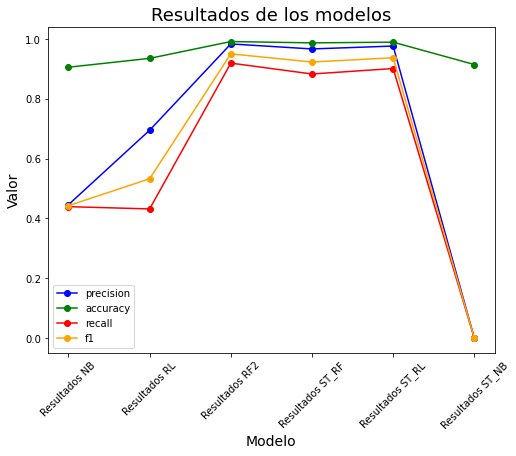

In [400]:
filas = ['precision', 'accuracy', 'recall', 'f1']

# tamaño del gráfico
plt.figure(figsize=(8, 6))

# colores a aplicar a cada modelo
colores = ['blue', 'green', 'red', 'orange', 'purple', 'brown']

# se itera sobre las filas y generar un gráfico para cada una
for i, fila in enumerate(filas):
    # datos de la fila
    datos = resultados.loc[fila]
    
    # gráfico de líneas
    plt.plot(datos.index, datos.values, color=colores[i], marker='o', label=fila)
    

plt.title('Resultados de los modelos', fontsize=18)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Valor', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Conclusiones Stacking

Se realizaron 3 combinaciones de Stacking con 3 algoritmos distintos: Random Forest, Naive Bayes y Regresión Logística, sin embargo ninguno de ellos obtuvo mejores resultados que el modelo Random Forest elegido previamente.

En este caso esto puede deberse a que los modelos base no son suficientemente independientes, ya que a pesar de ser algoritmos distintos, utilizamos las mismas variables predictoras y el mismo dataset.
Por otro lado también se puede explicar porque el modelo Random Forest por sí solo está logrando un rendimiento superior en términos de precisión y exhaustividad.

Por lo tanto, al analizar estos resultados, concluimos que seguimos manteniendo la elección del modelo Random Forest 2 como mejor modelo.